In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [3]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

In [7]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [8]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

====> Test set loss: 544.4362
====> Epoch: 1 Average loss: 189.6120
====> Test set loss: 136.5999
====> Epoch: 2 Average loss: 132.3452
====> Test set loss: 116.5991
====> Epoch: 3 Average loss: 121.4357
====> Test set loss: 108.9056
====> Epoch: 4 Average loss: 116.3917
====> Test set loss: 105.5717
====> Epoch: 5 Average loss: 113.5049
====> Test set loss: 103.3772
====> Epoch: 6 Average loss: 111.6632
====> Test set loss: 101.6865
====> Epoch: 7 Average loss: 110.3349
====> Test set loss: 101.3007
====> Epoch: 8 Average loss: 109.3731
====> Test set loss: 99.5936
====> Epoch: 9 Average loss: 108.6410
====> Test set loss: 98.7547
====> Epoch: 10 Average loss: 107.9758
====> Test set loss: 98.8005


<ipython-input-2-febedcb7ee00>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))
<ipython-input-2-febedcb7ee00>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))


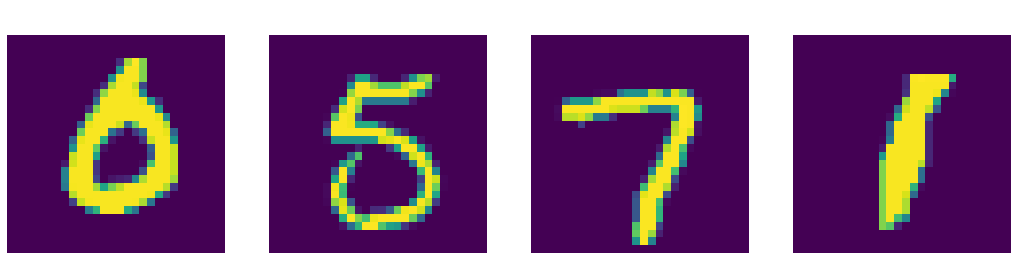

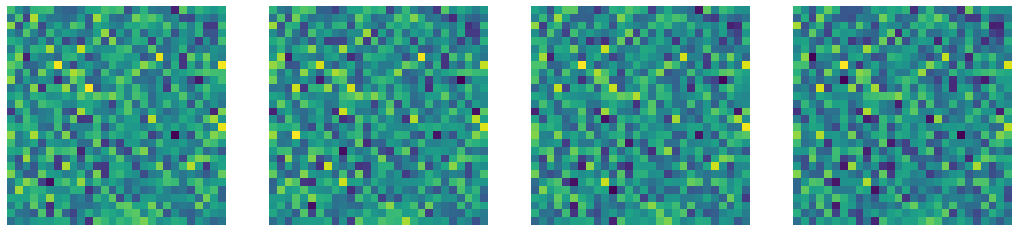

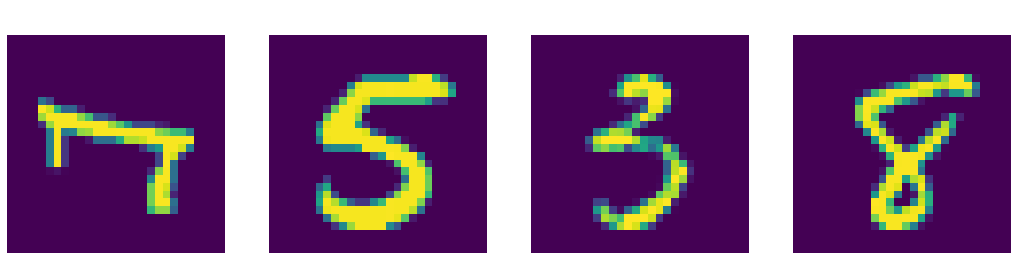

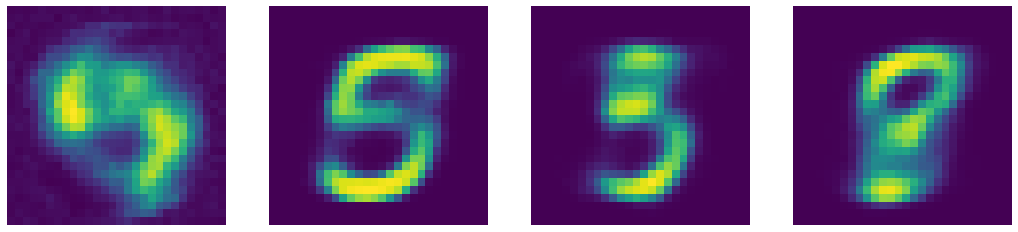

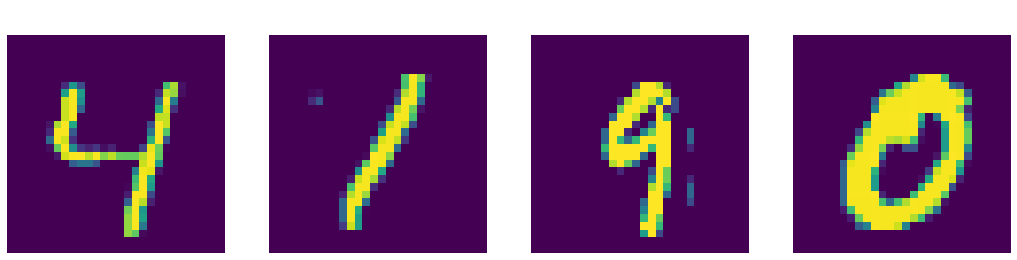

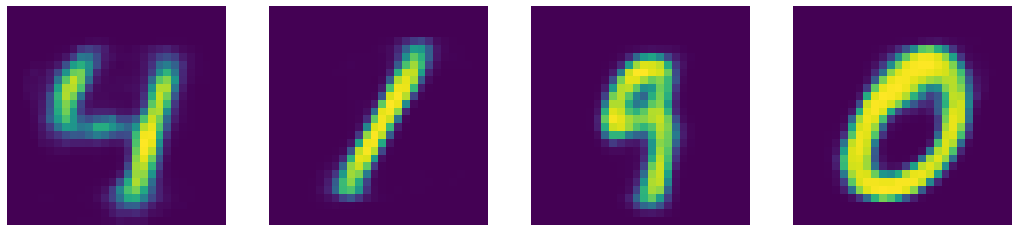

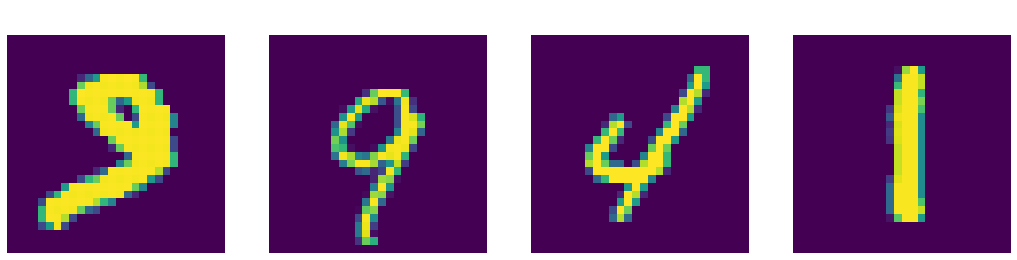

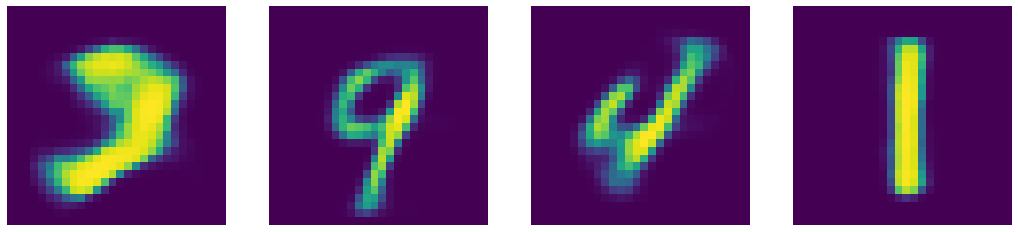

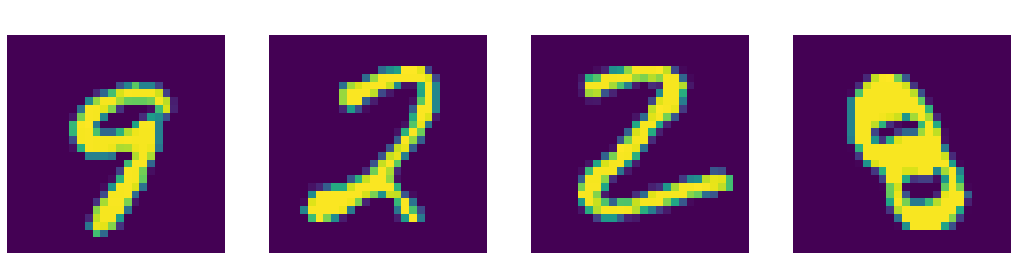

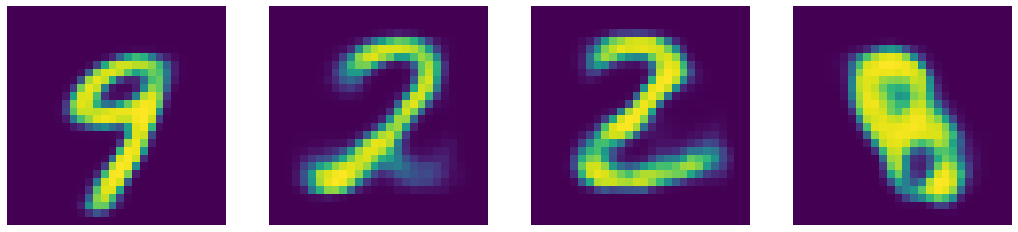

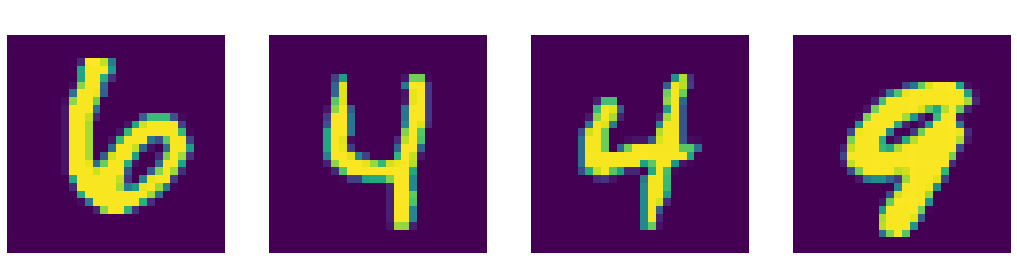

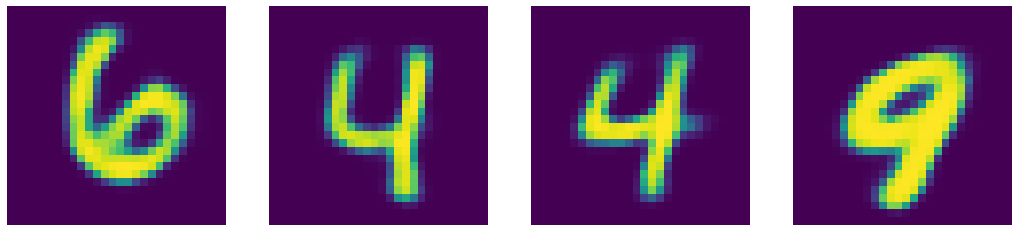

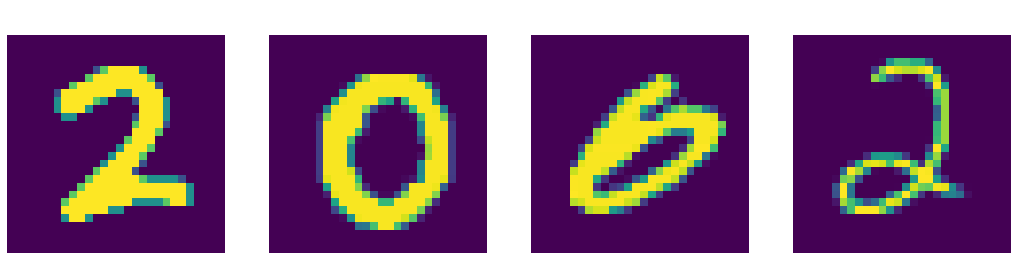

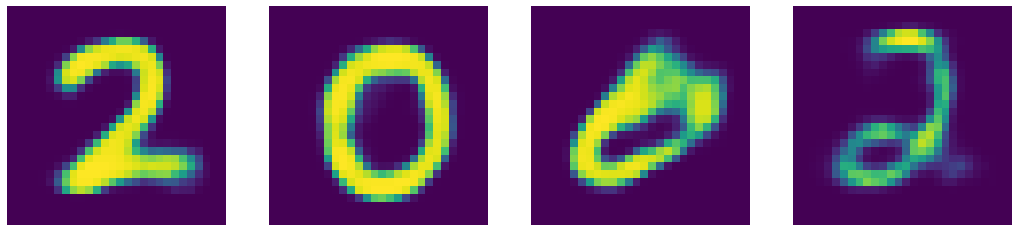

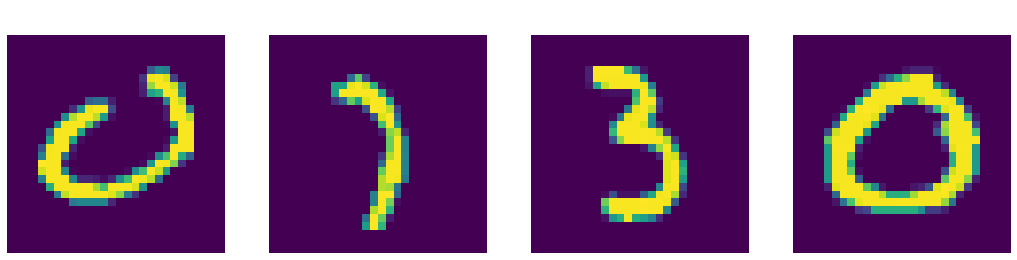

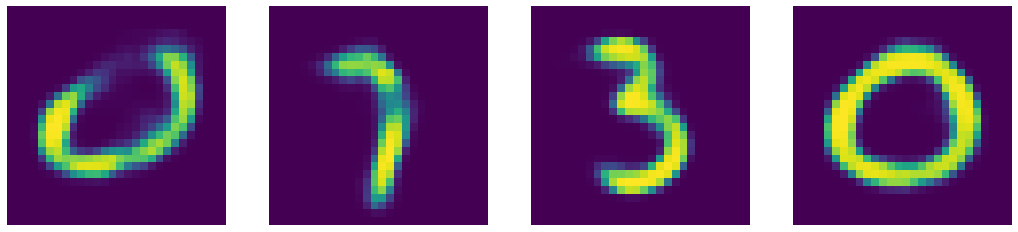

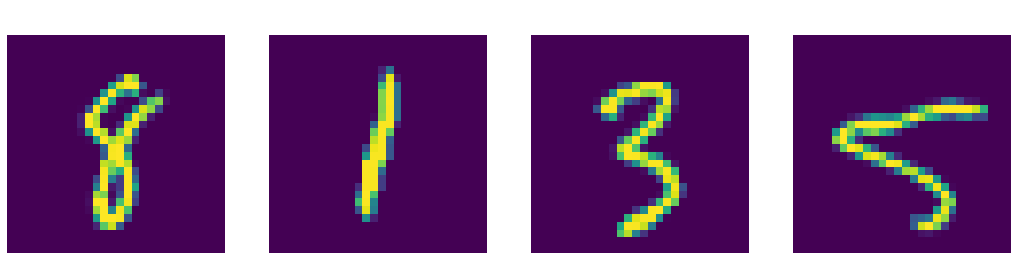

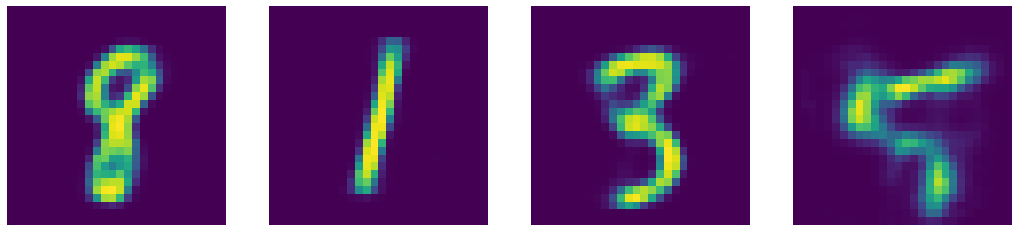

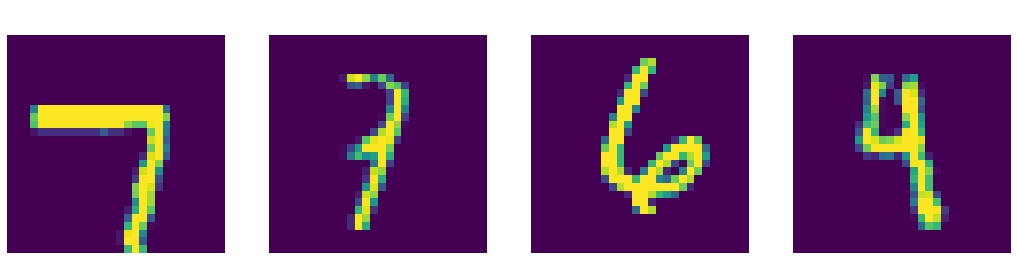

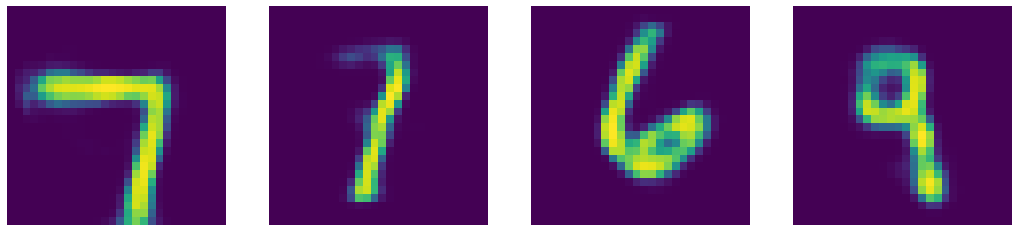

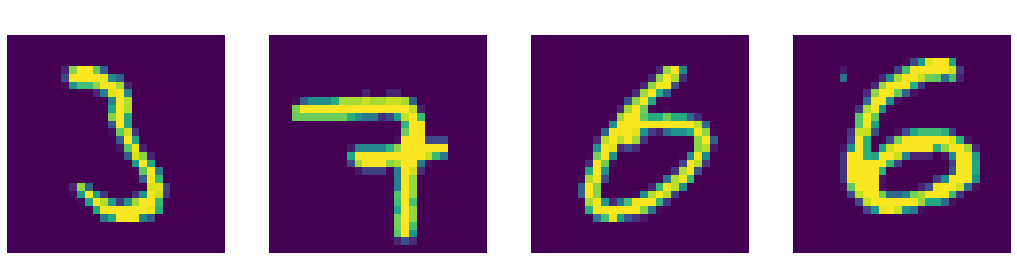

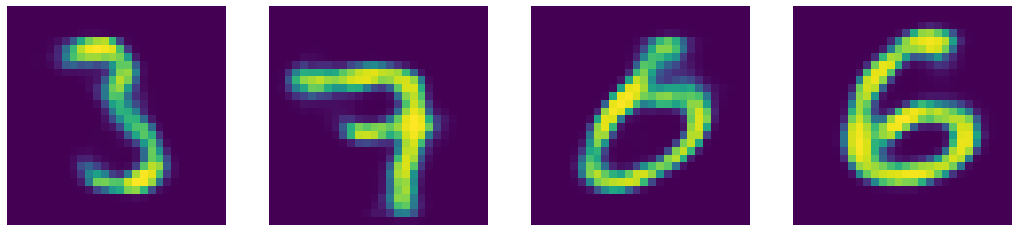

In [10]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

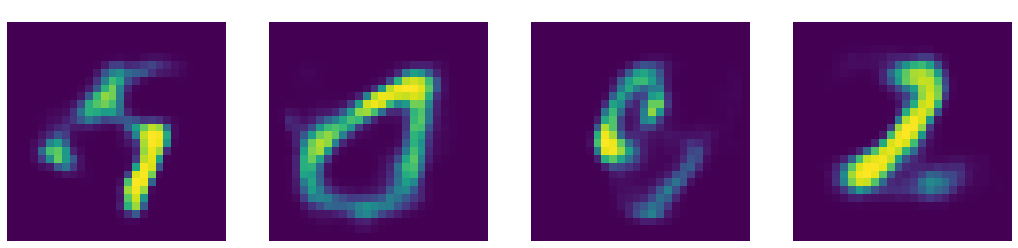

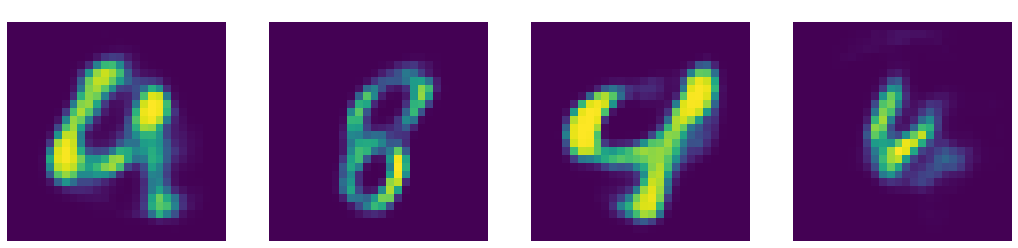

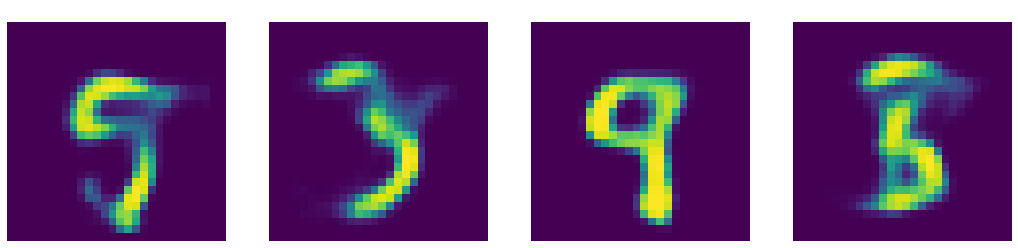

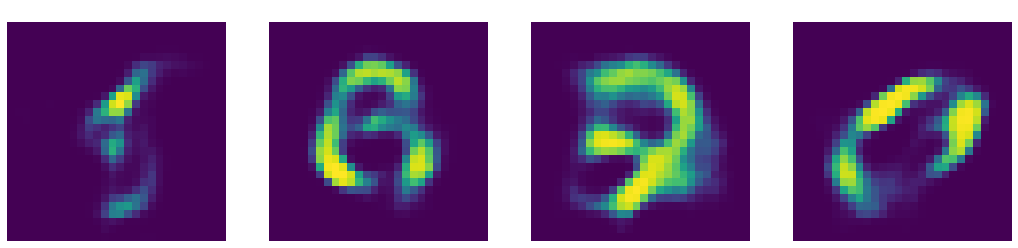

In [11]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

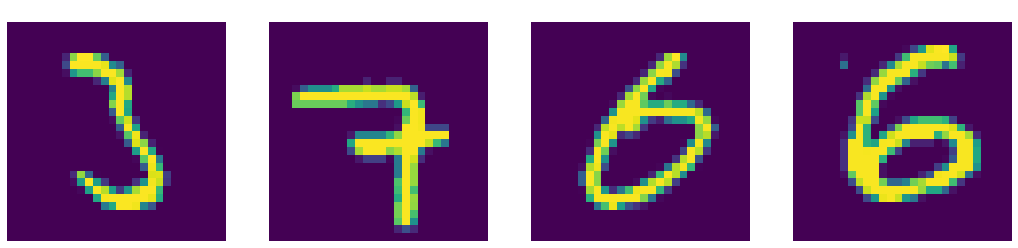

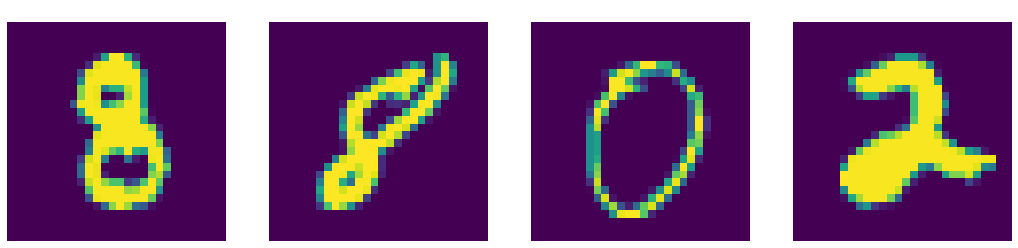

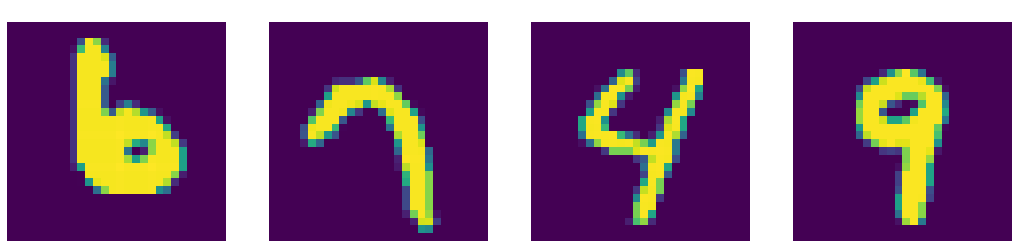

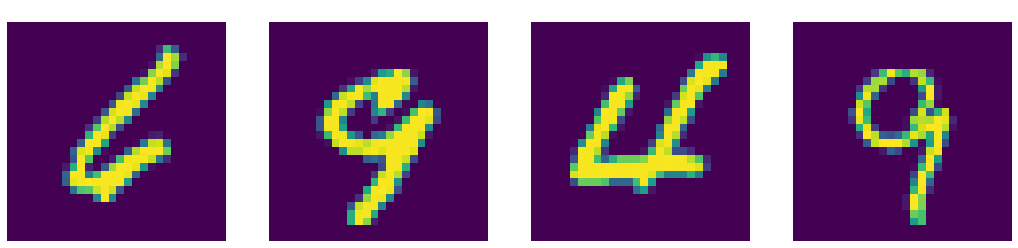

In [12]:
# Display last test batch

display_images(None, x, 4, count=True)

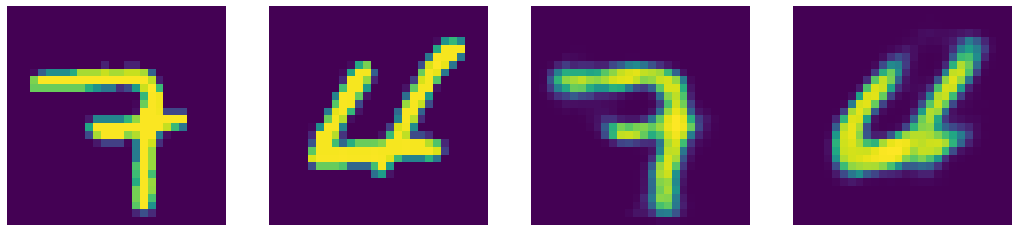

In [13]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

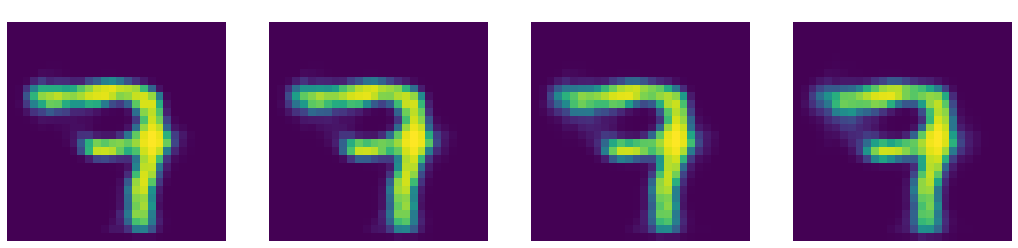

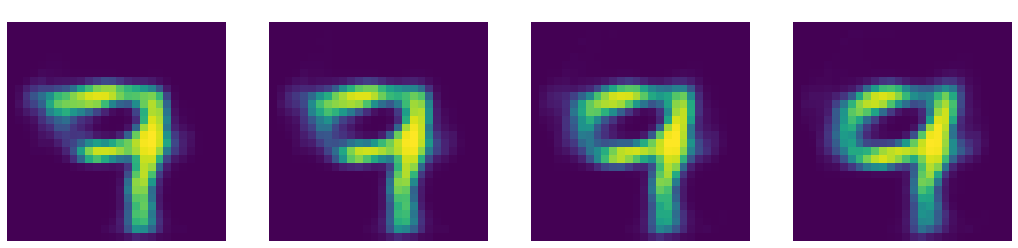

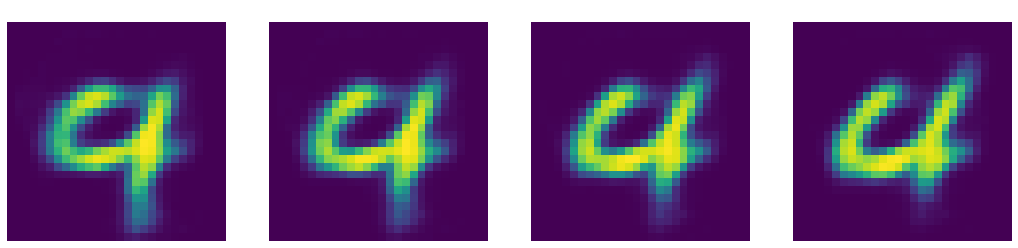

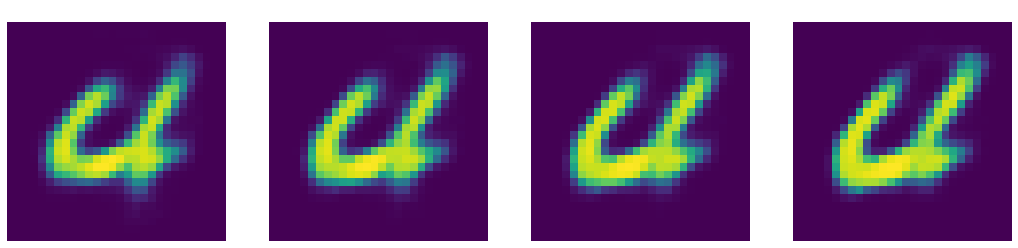

In [14]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

In [15]:
import numpy as np
from sklearn.manifold import TSNE
from res.plot_lib import set_default

In [16]:
set_default(figsize=(15, 4))

In [18]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].cpu()))
    Y.append(codes['y'][epoch][:N])

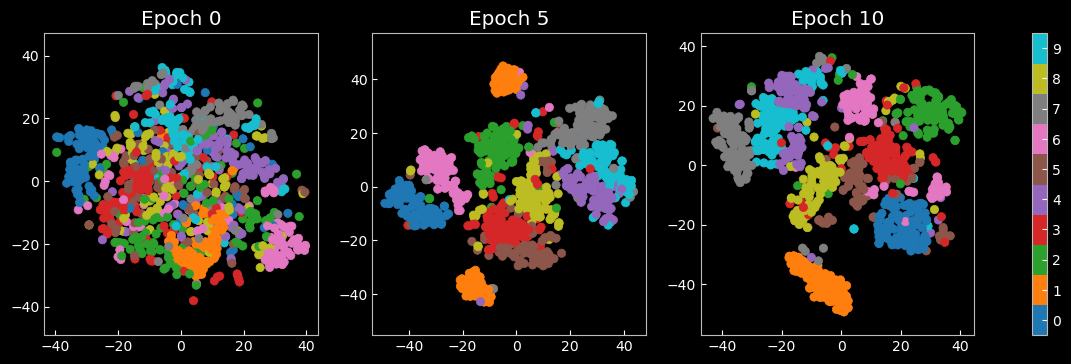

In [19]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)

## Add some convolutional layers

In [43]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # n x 32 x 14 x 14
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # n x 64 x 7 x 7
            nn.Conv2d(64, 128, 3, padding=0),  # n x 128 x 5 x 5
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=0),  # n x 256 x 3 x 3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, 3, padding=0),  # n x 512 x 1 x 1
            nn.ReLU(inplace=True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(512, d * 2)
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(d, 64*16*16),
            nn.BatchNorm1d(64*16*16),
            nn.ReLU(inplace=True),
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7, stride=1),  # 22 x 22
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 7, stride=1),  # 28 x 28
            nn.Sigmoid()
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        mu_logvar = self.encoder_lin(x).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        
        x = self.decoder_lin(z)
        x = x.view(x.size(0), 64, 16, 16)
        x = self.decoder_conv(x)
        return x, mu, logvar
    
    def decode(self, z):
        x = self.decoder_lin(z)
        x = x.view(x.size(0), 64, 16, 16)
        x = self.decoder_conv(x)
        return x

model = VAE().to(device)

In [44]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [45]:
# Reconstruction + KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat.view(-1, 784), x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD

====> Test set loss: 511.5634
====> Epoch: 1 Average loss: 177.5428
====> Test set loss: 115.1369
====> Epoch: 2 Average loss: 116.6082
====> Test set loss: 102.9540
====> Epoch: 3 Average loss: 110.3903
====> Test set loss: 101.6009
====> Epoch: 4 Average loss: 107.7480
====> Test set loss: 98.5085
====> Epoch: 5 Average loss: 105.9876
====> Test set loss: 99.7438
====> Epoch: 6 Average loss: 104.9095
====> Test set loss: 95.3826
====> Epoch: 7 Average loss: 104.2831
====> Test set loss: 95.2174
====> Epoch: 8 Average loss: 103.4891
====> Test set loss: 95.2479
====> Epoch: 9 Average loss: 102.8564
====> Test set loss: 95.2426
====> Epoch: 10 Average loss: 102.4700
====> Test set loss: 96.1840


<ipython-input-2-febedcb7ee00>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))
<ipython-input-2-febedcb7ee00>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 6))


====> Epoch: 11 Average loss: 102.0683
====> Test set loss: 93.4215
====> Epoch: 12 Average loss: 101.5989
====> Test set loss: 94.4891
====> Epoch: 16 Average loss: 100.5031
====> Test set loss: 93.0327
====> Epoch: 17 Average loss: 100.2830
====> Test set loss: 91.7311
====> Epoch: 18 Average loss: 100.0690
====> Test set loss: 92.1918
====> Epoch: 19 Average loss: 99.8453
====> Test set loss: 91.6667
====> Epoch: 20 Average loss: 99.7913
====> Test set loss: 91.1026


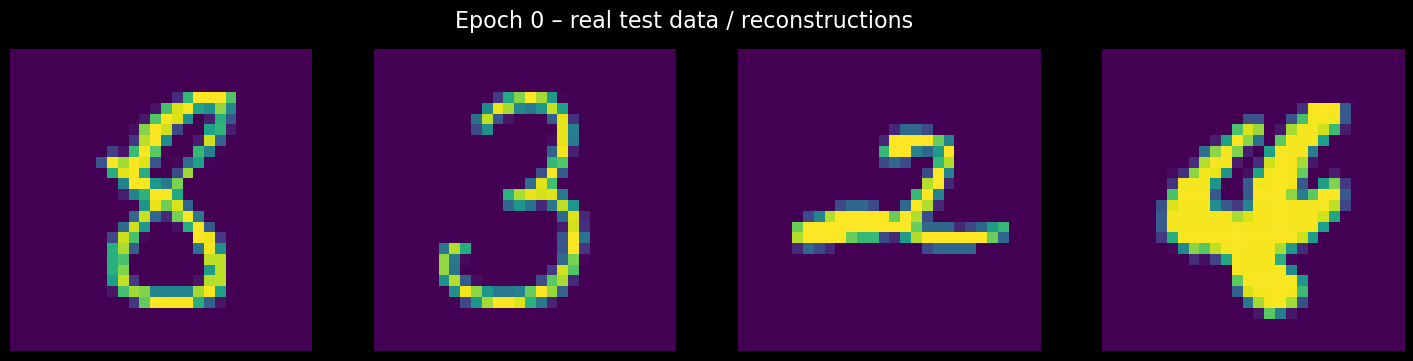

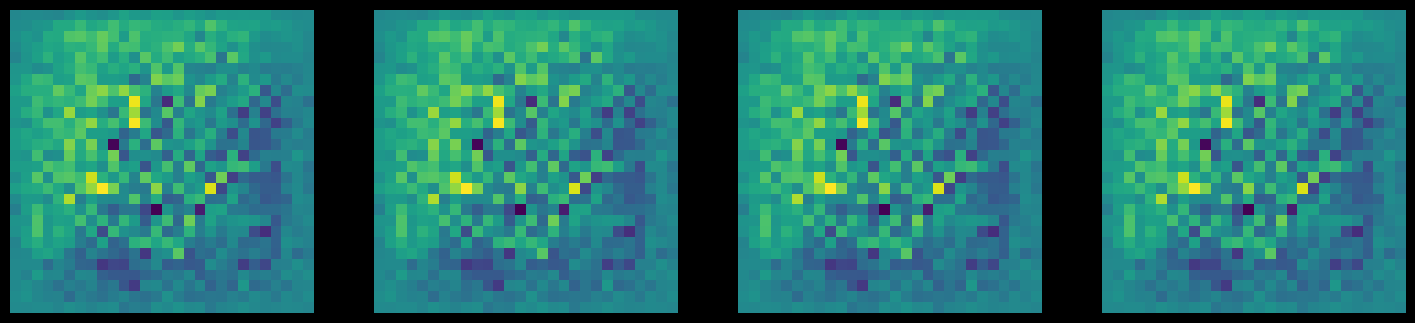

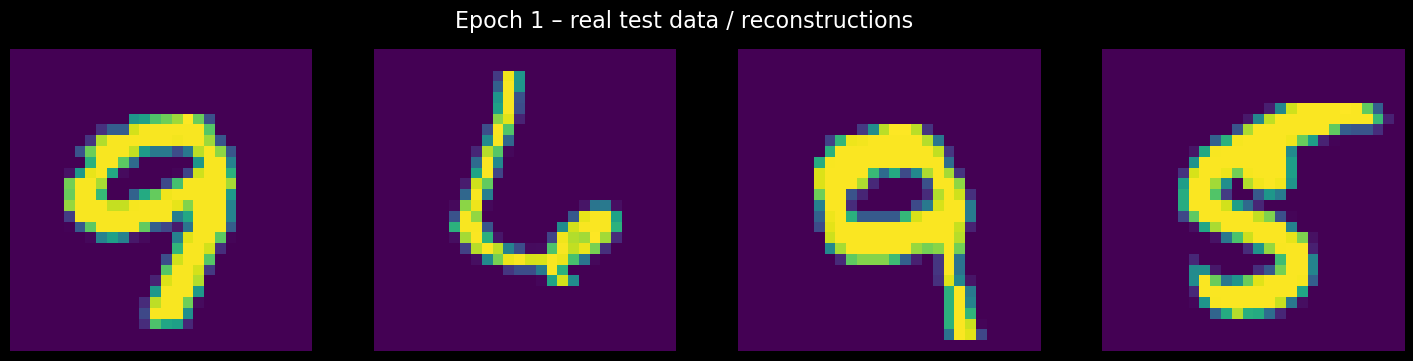

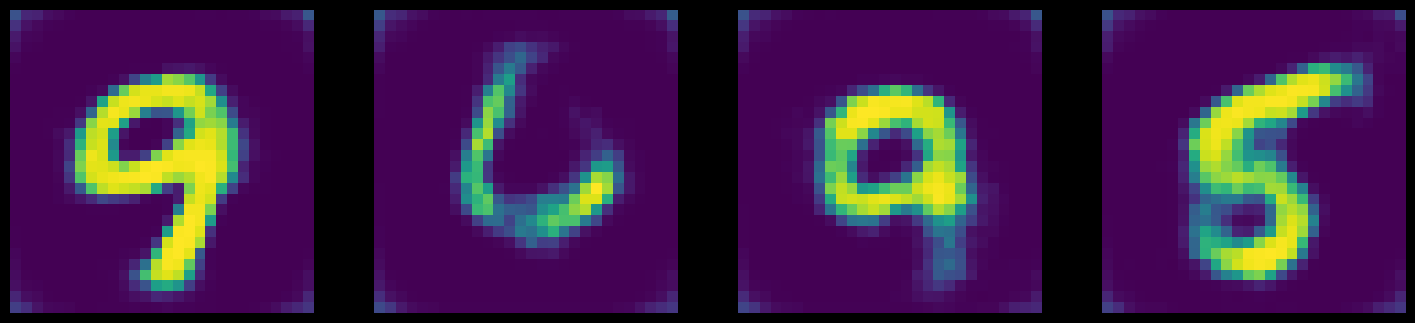

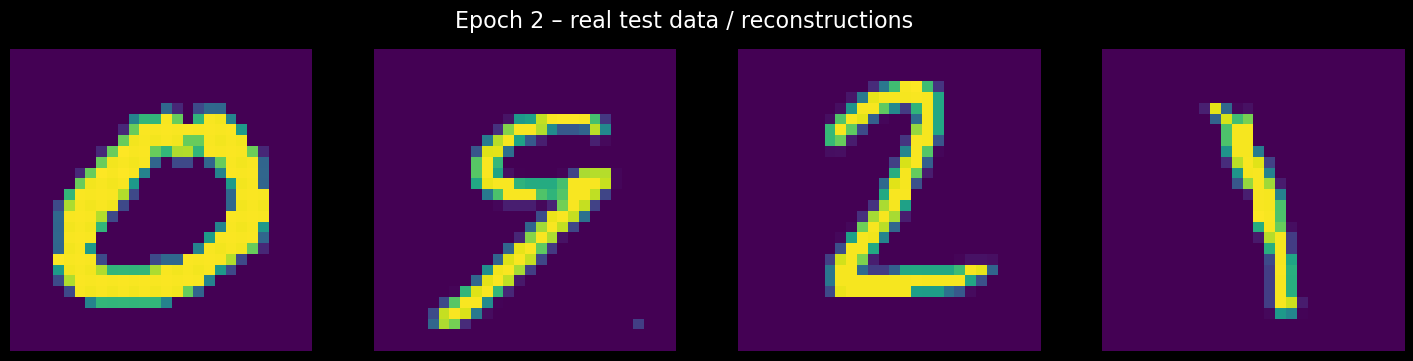

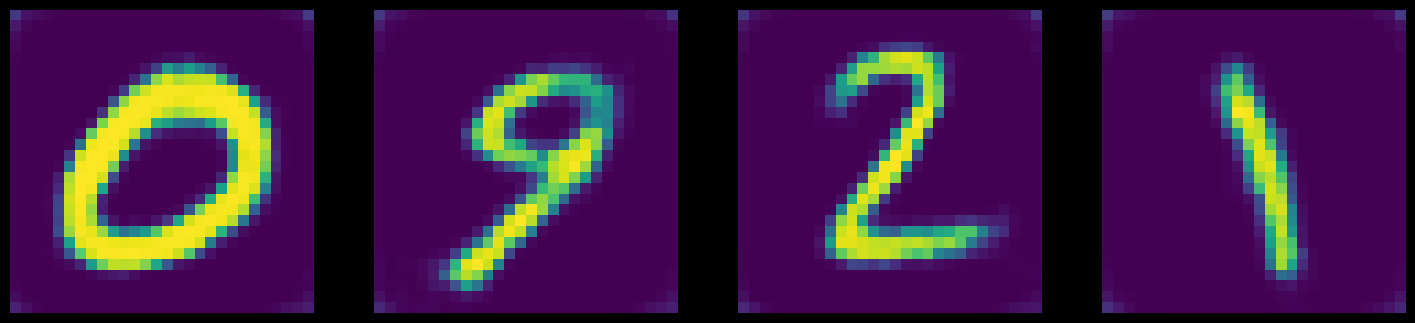

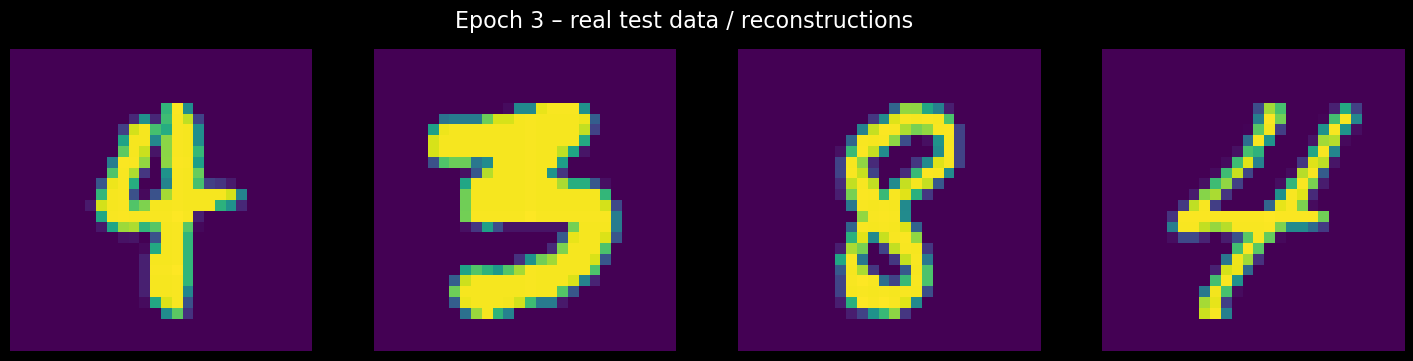

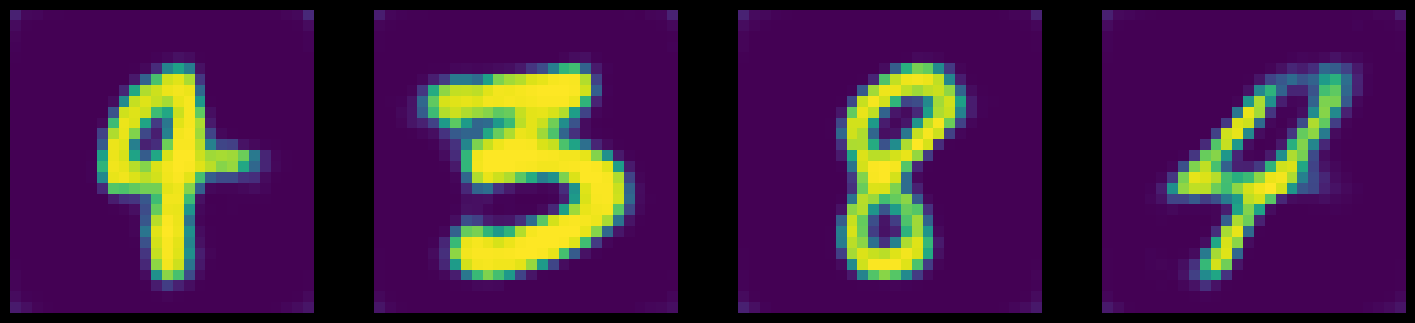

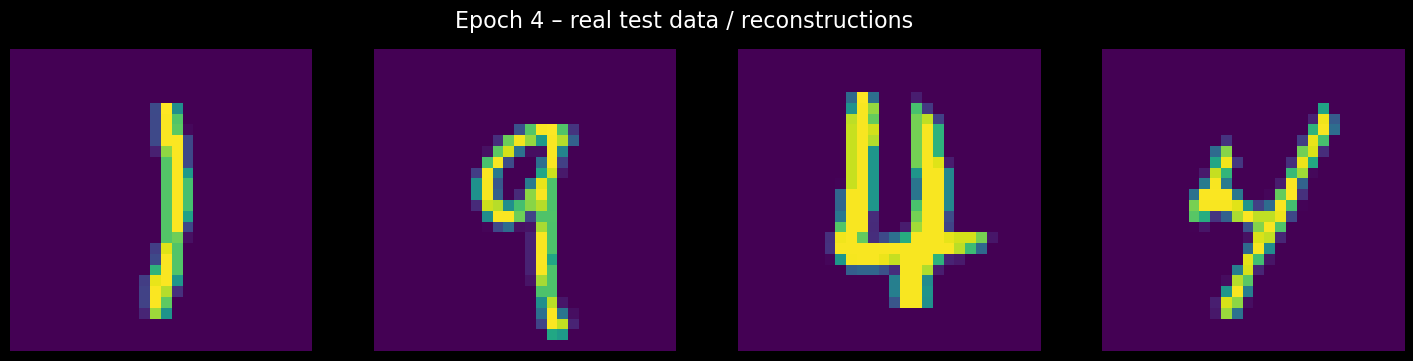

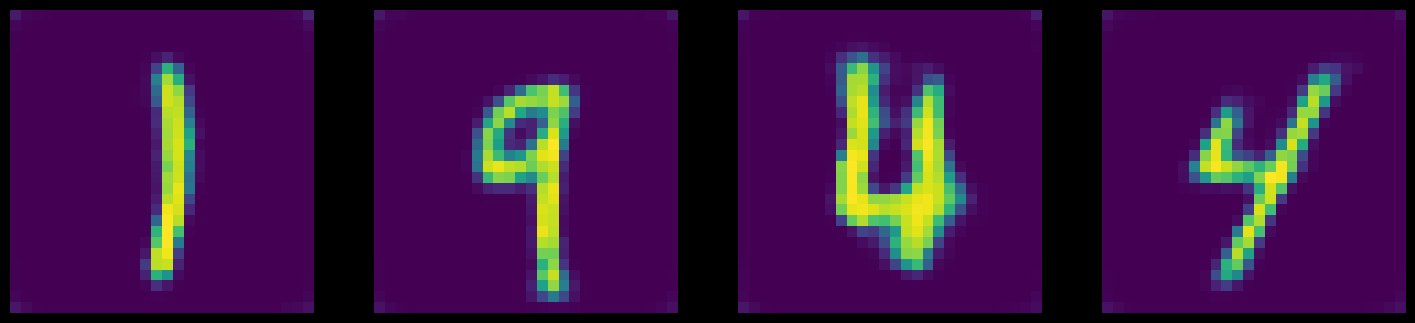

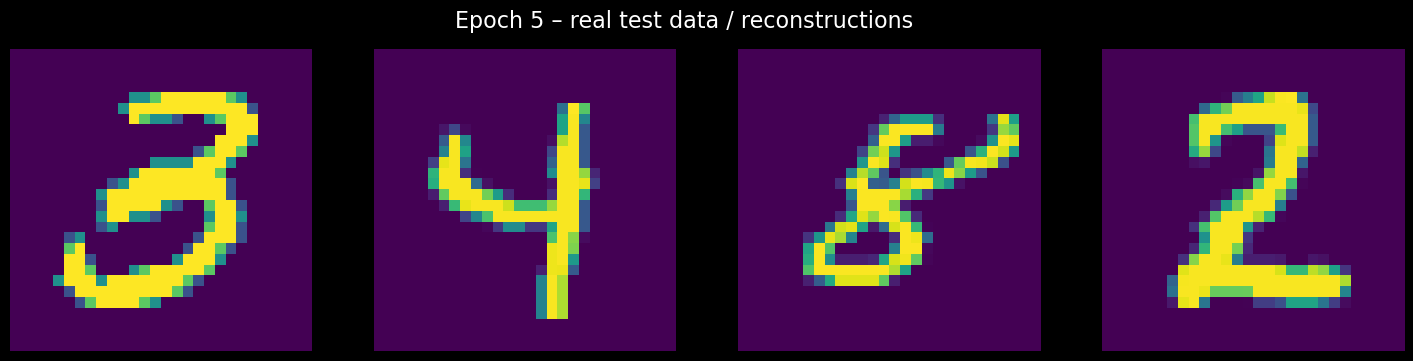

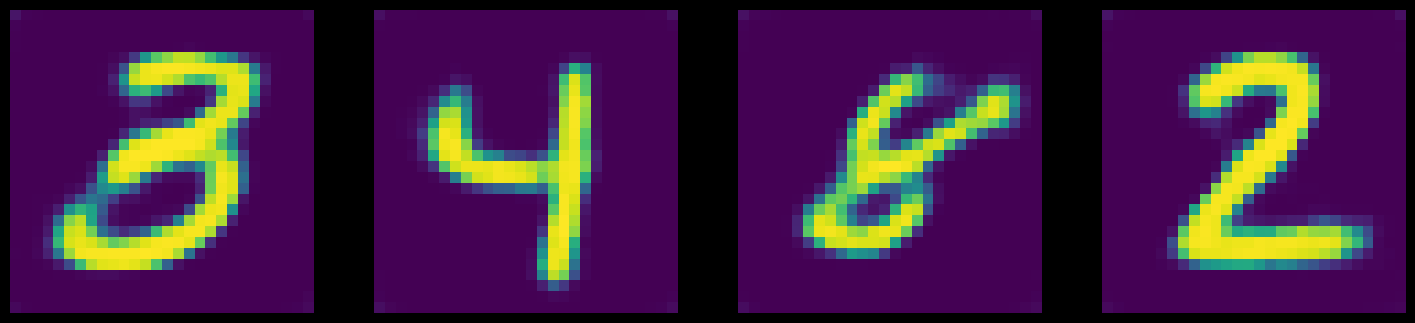

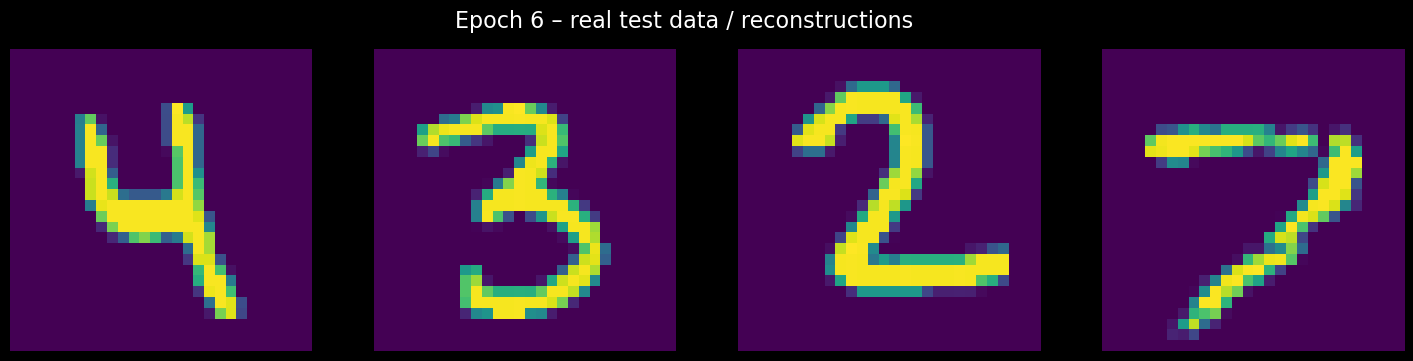

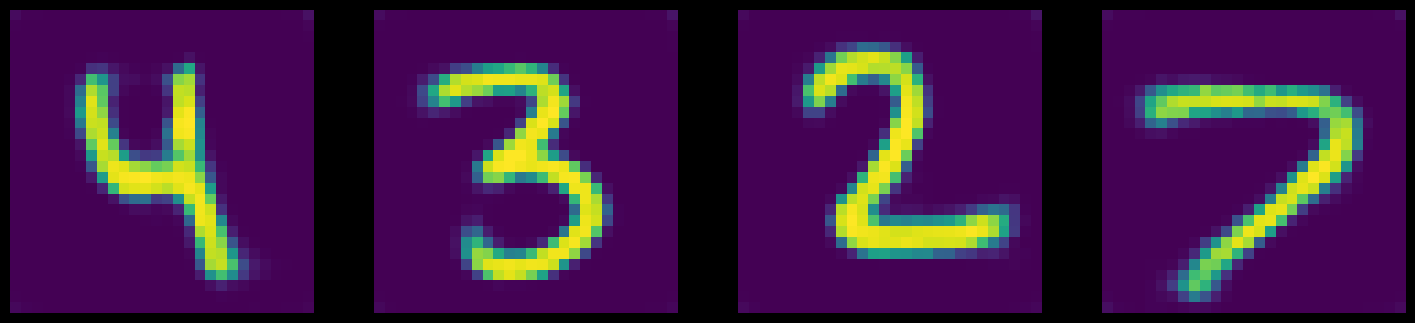

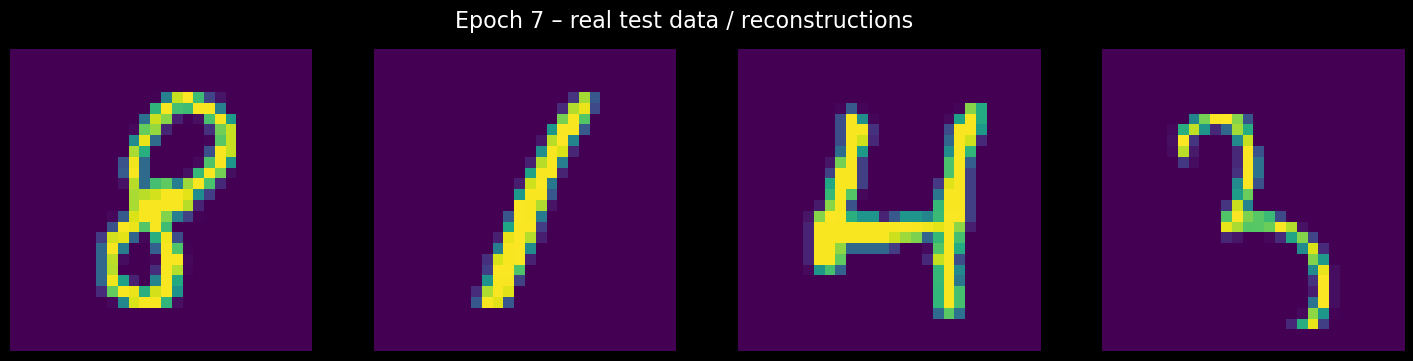

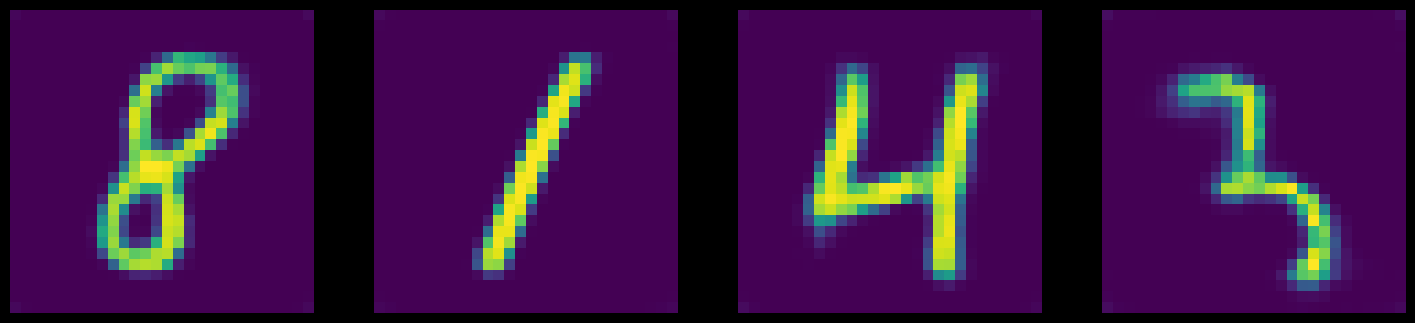

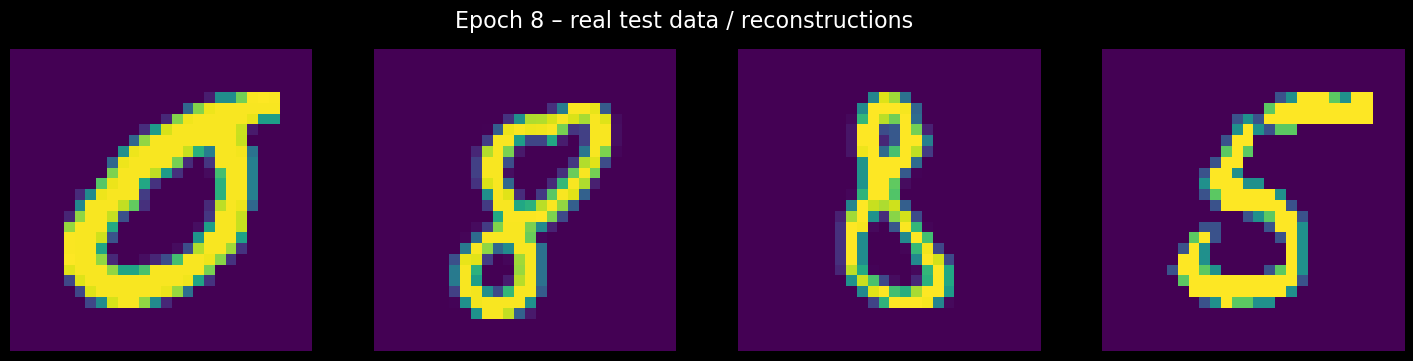

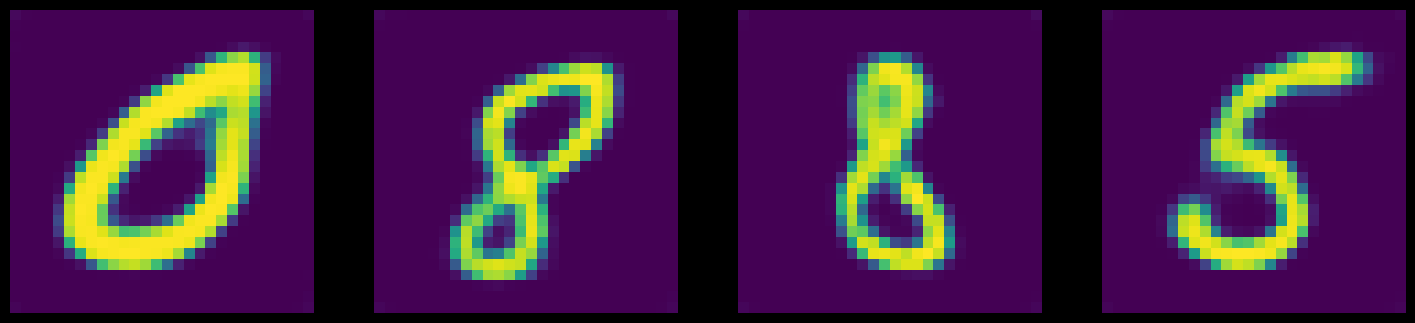

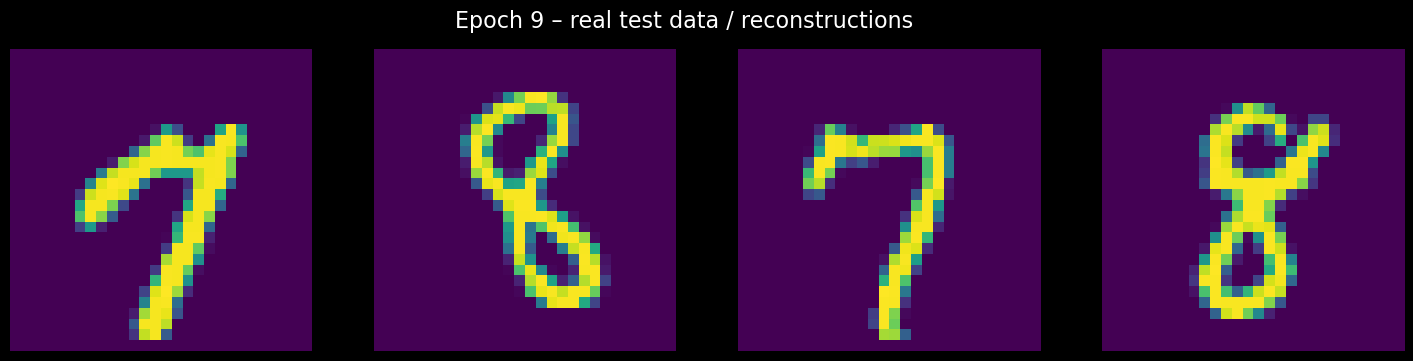

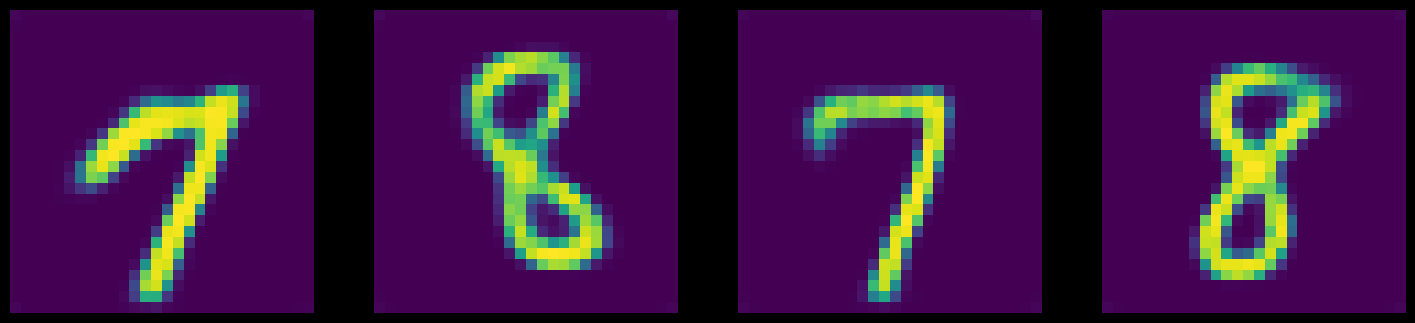

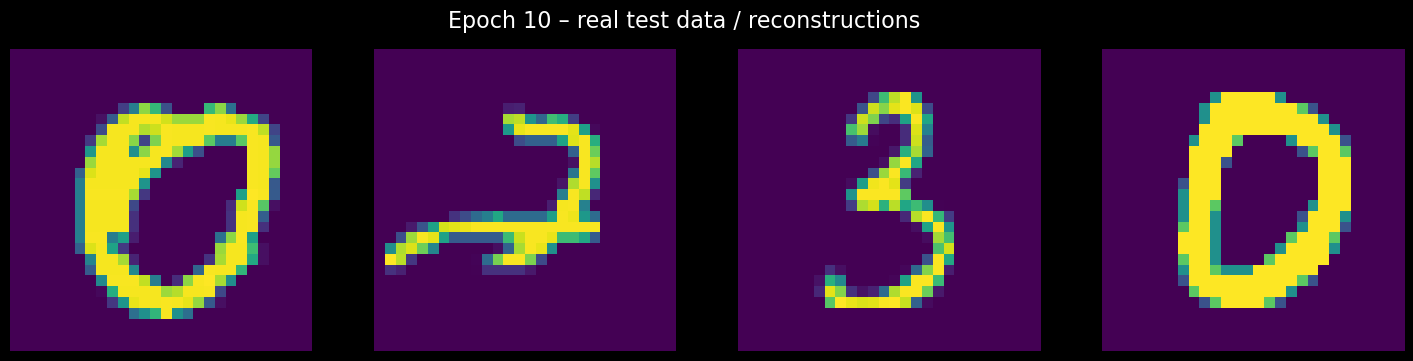

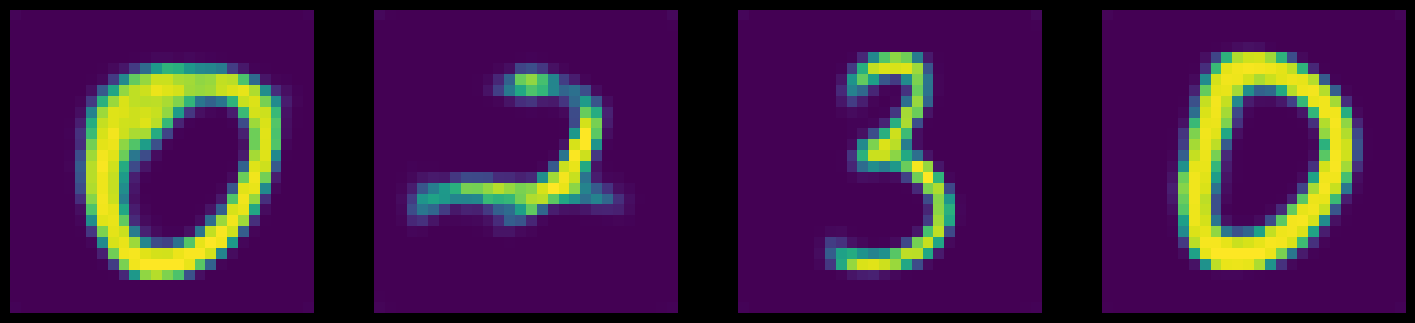

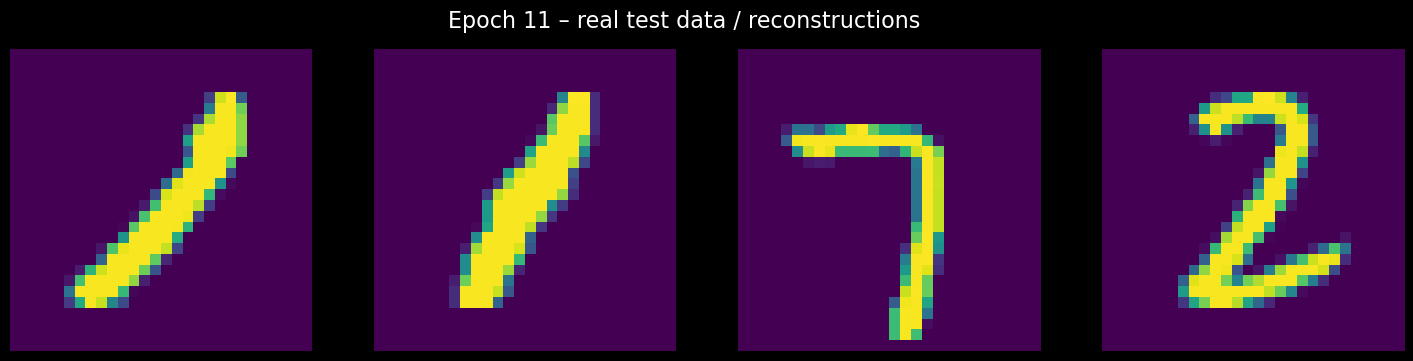

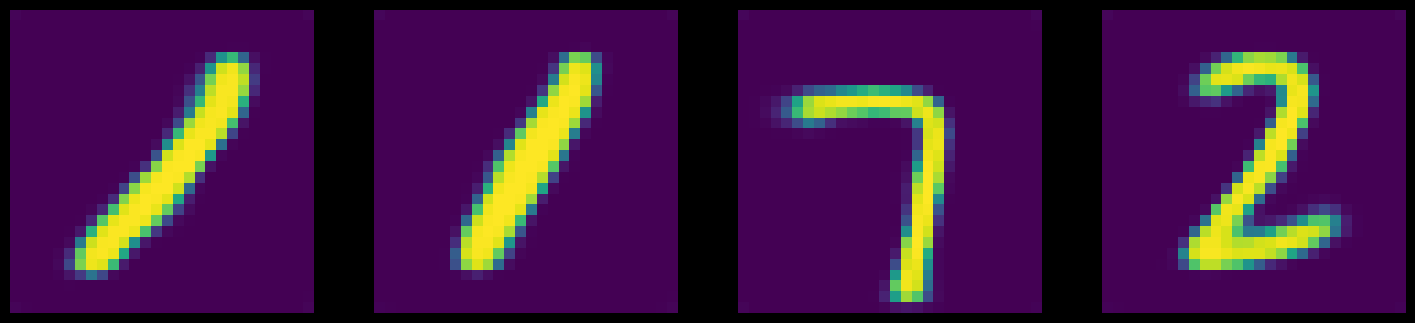

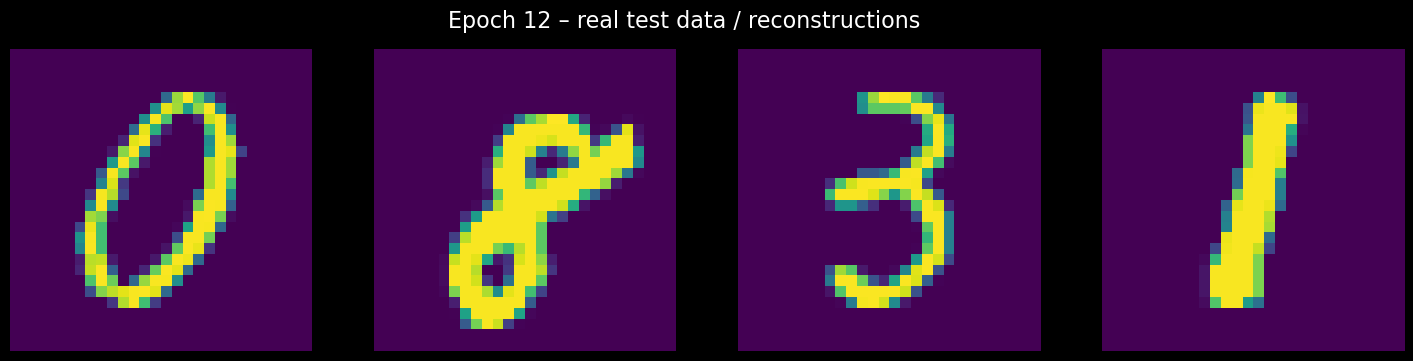

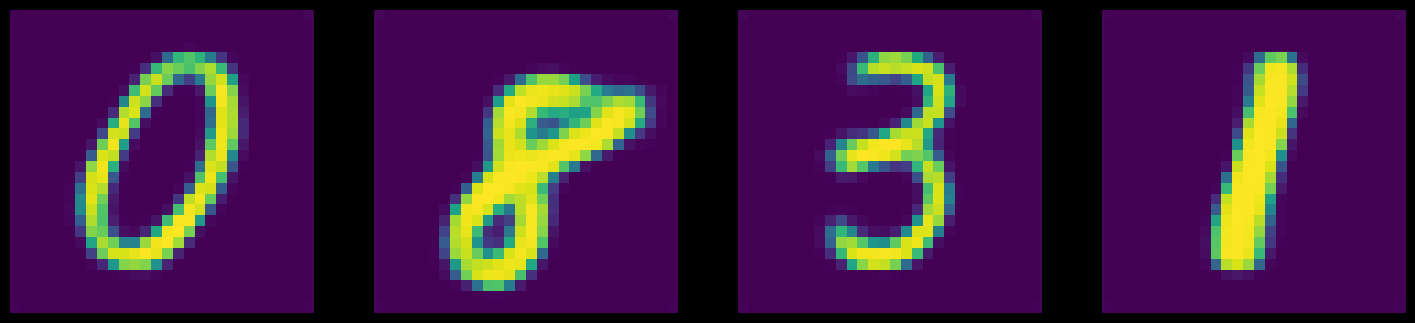

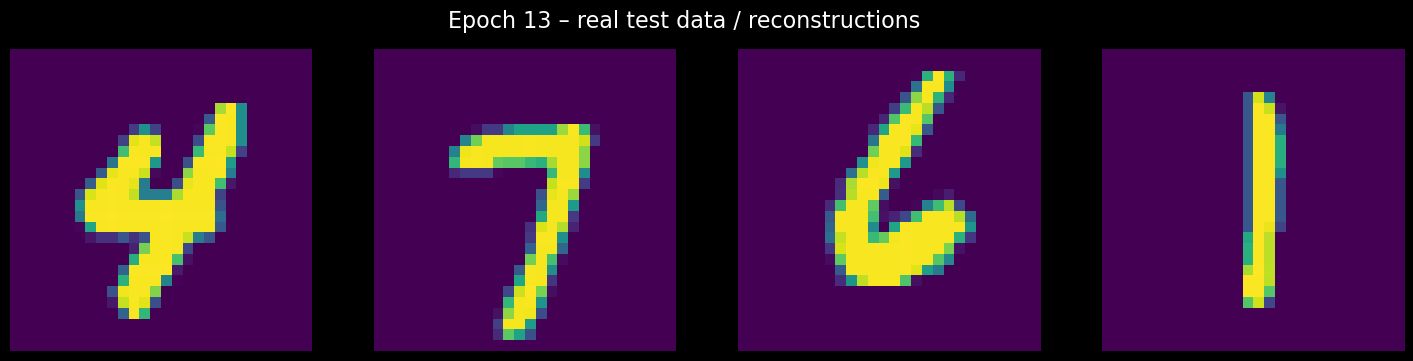

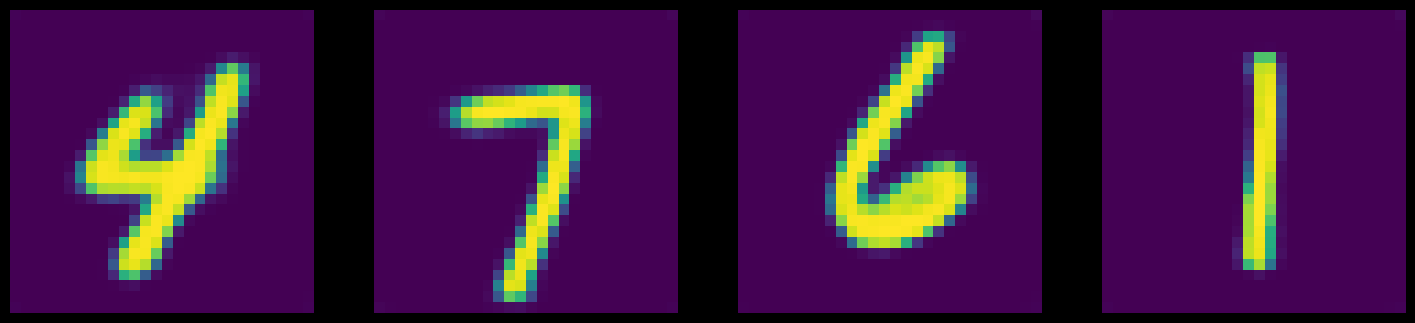

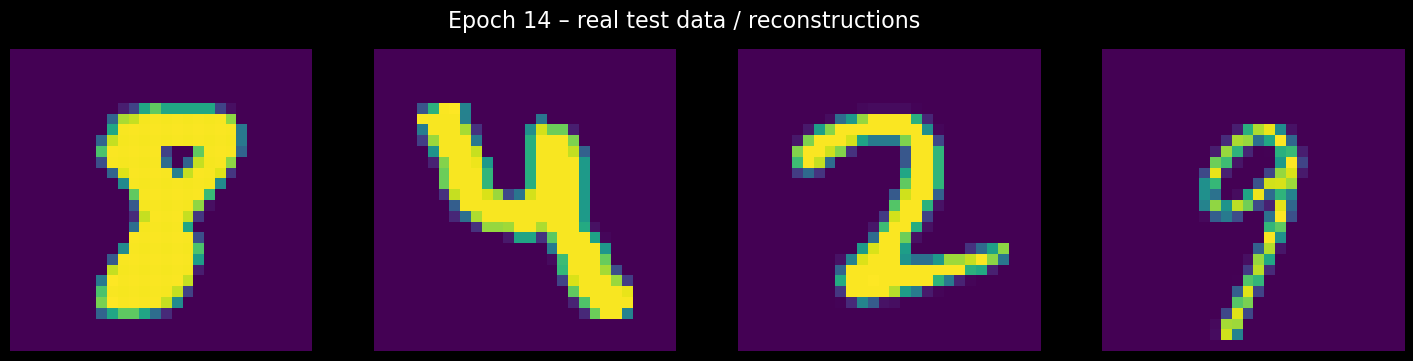

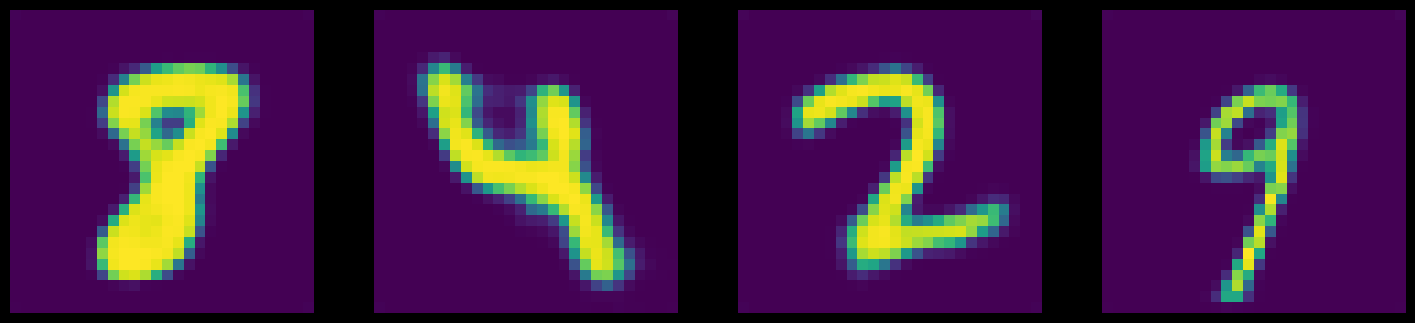

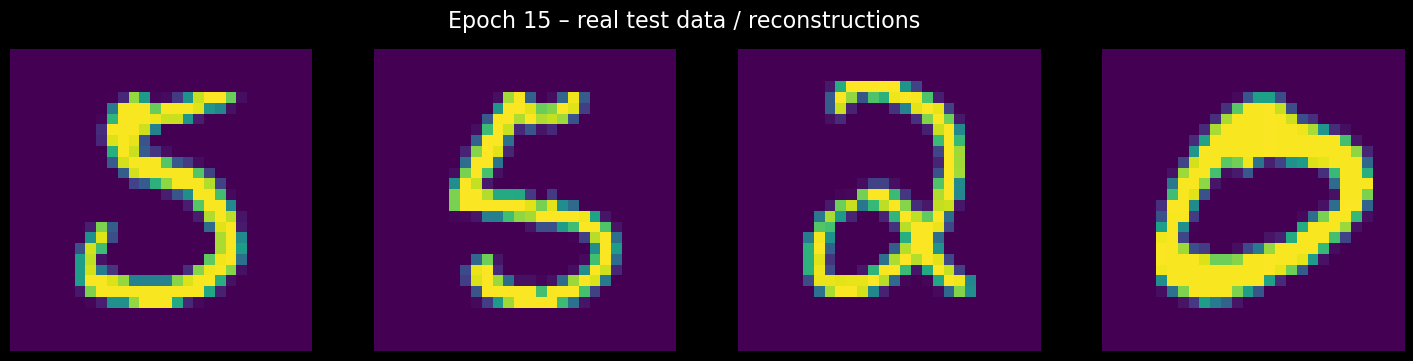

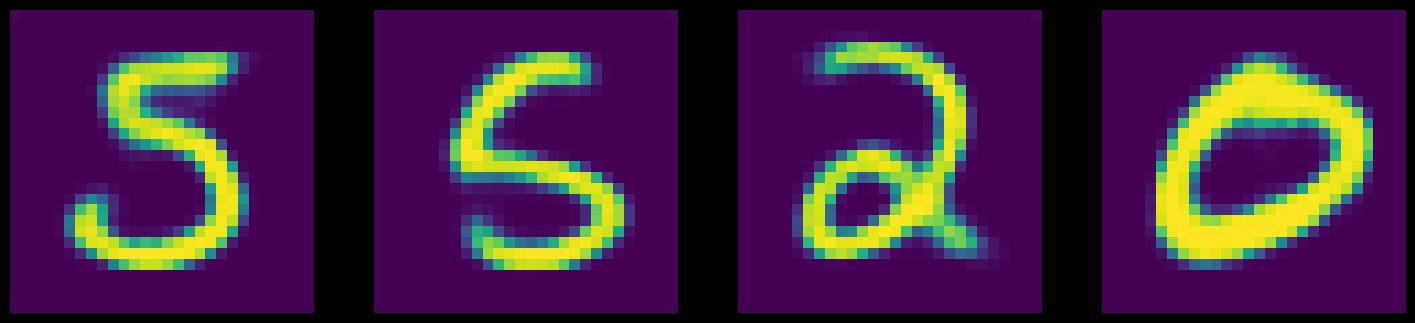

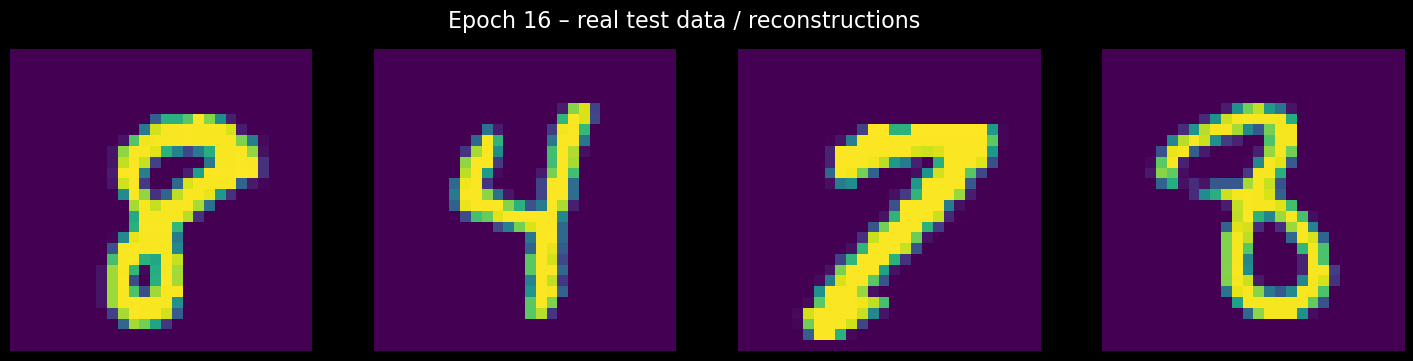

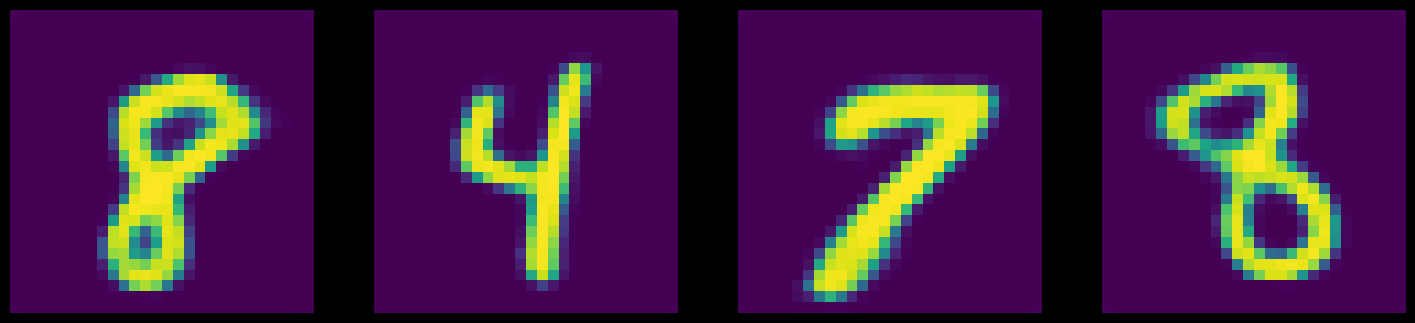

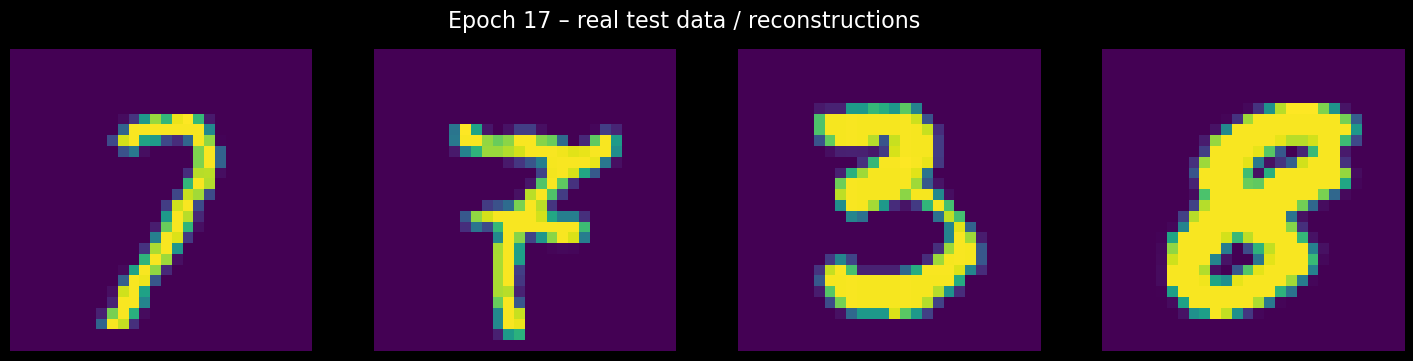

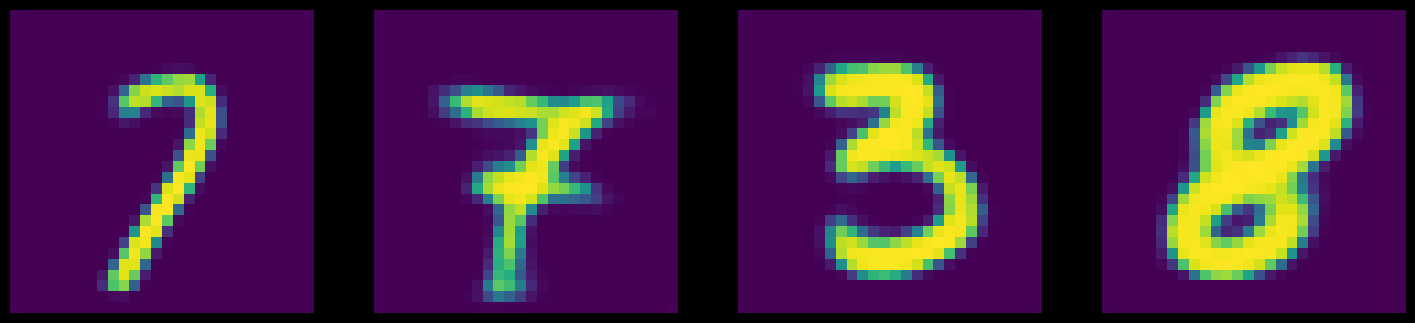

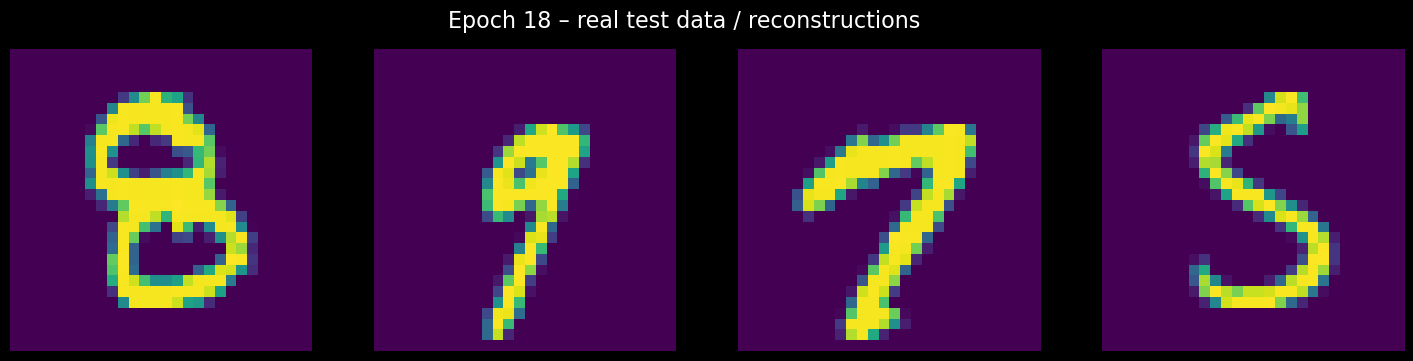

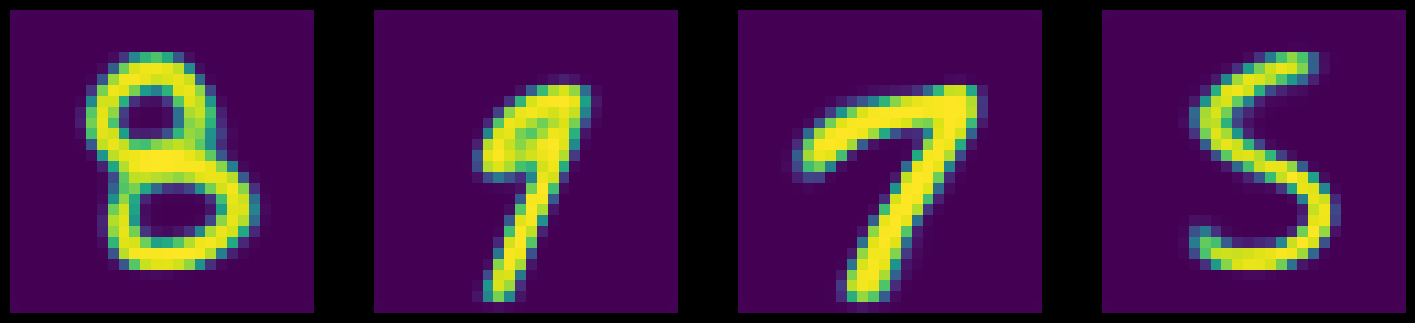

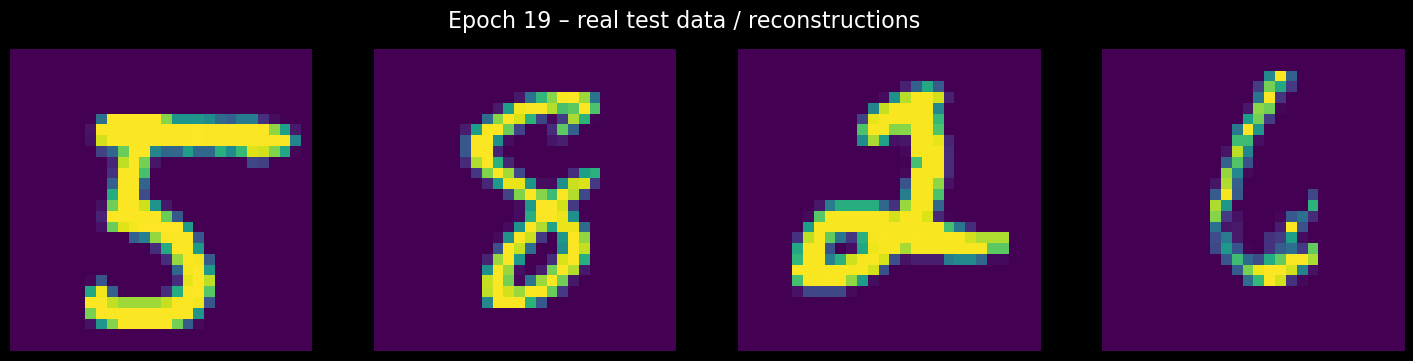

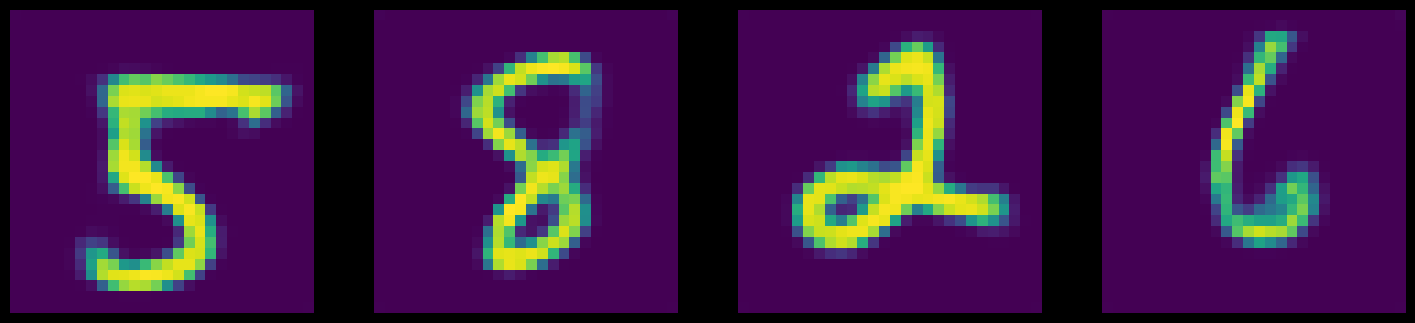

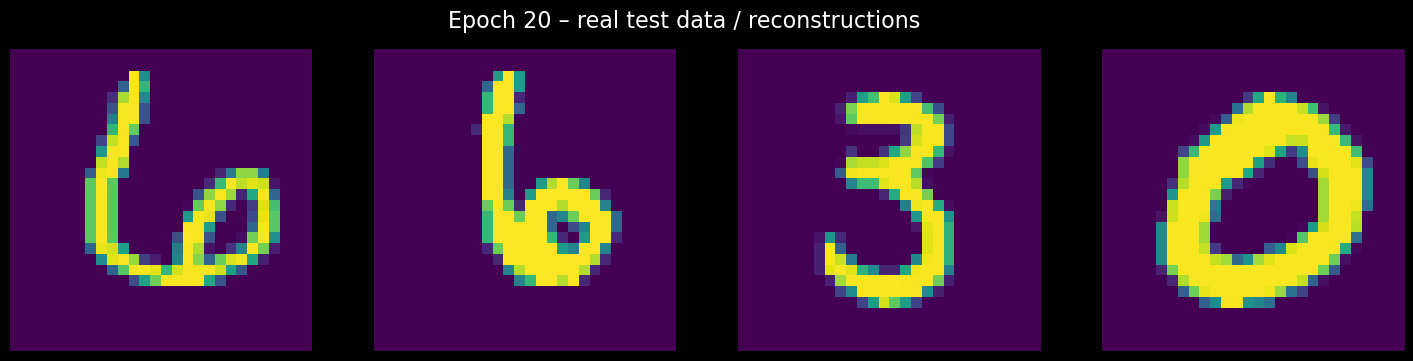

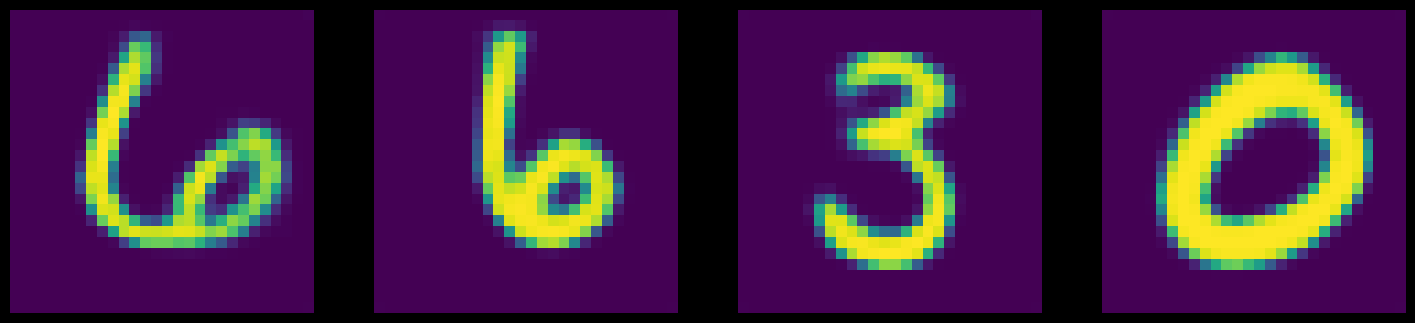

In [46]:
# Training and testing the VAE

epochs = 20
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

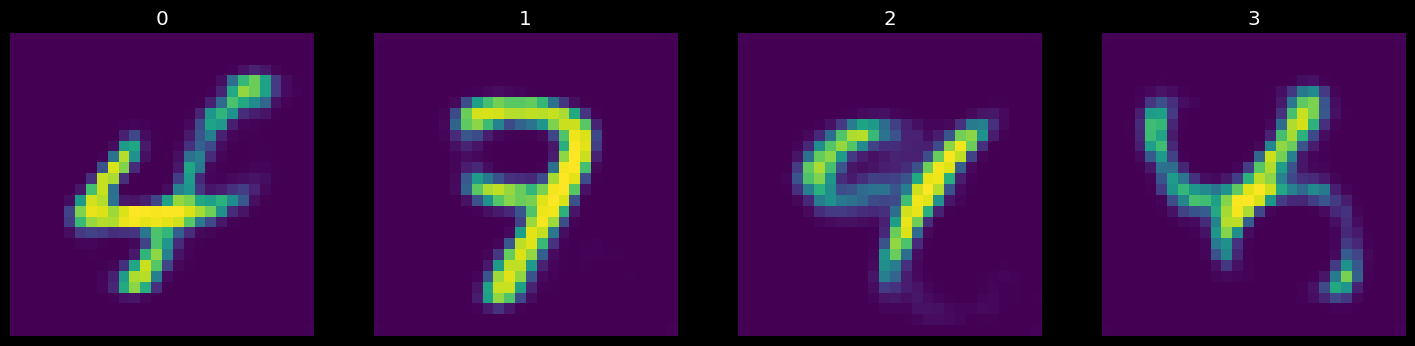

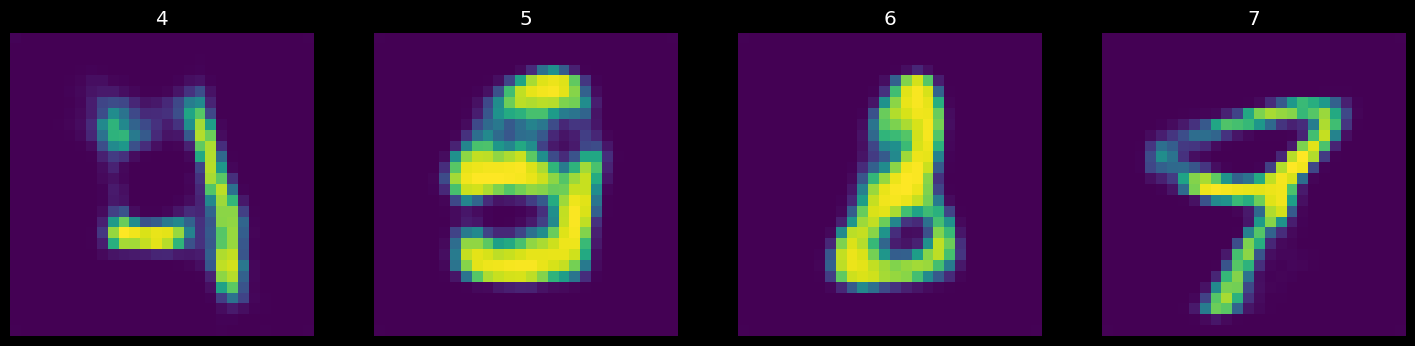

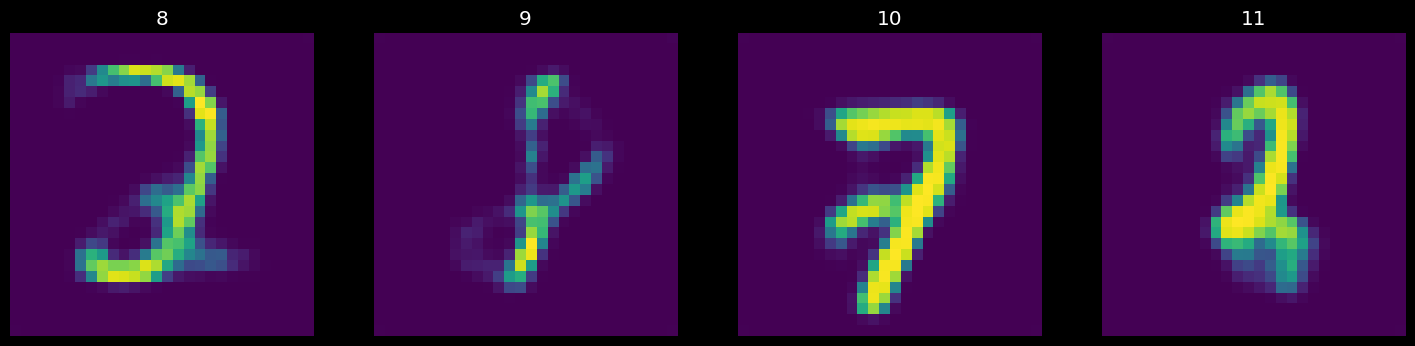

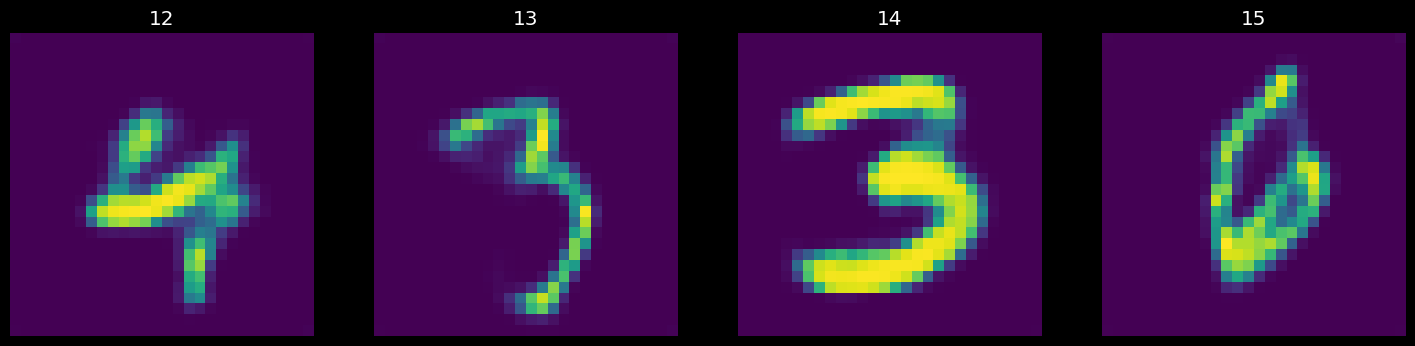

In [47]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)

x = model.decode(z)

display_images(None, sample, N // 4, count=True)

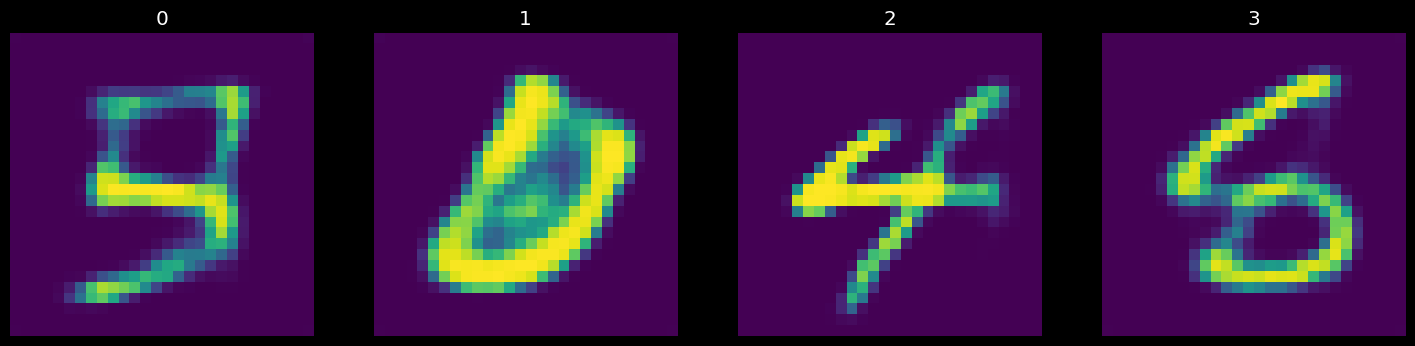

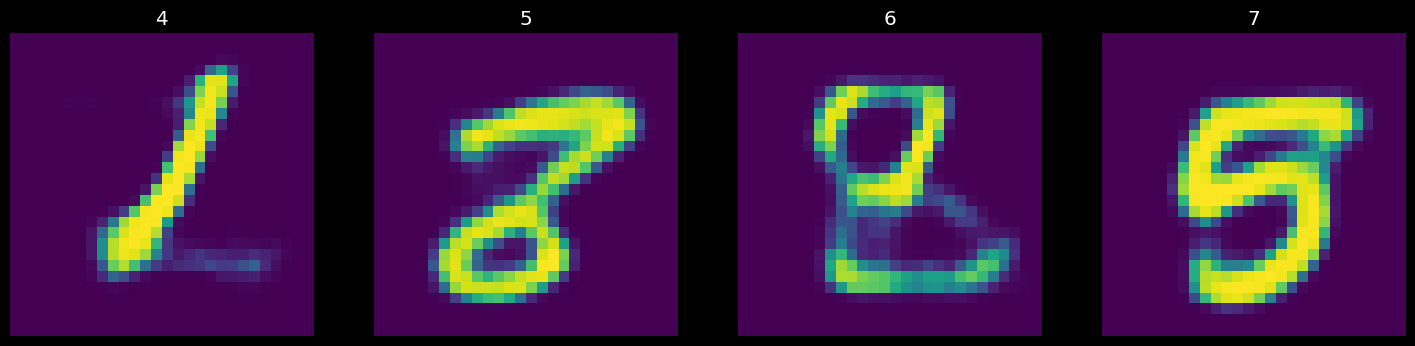

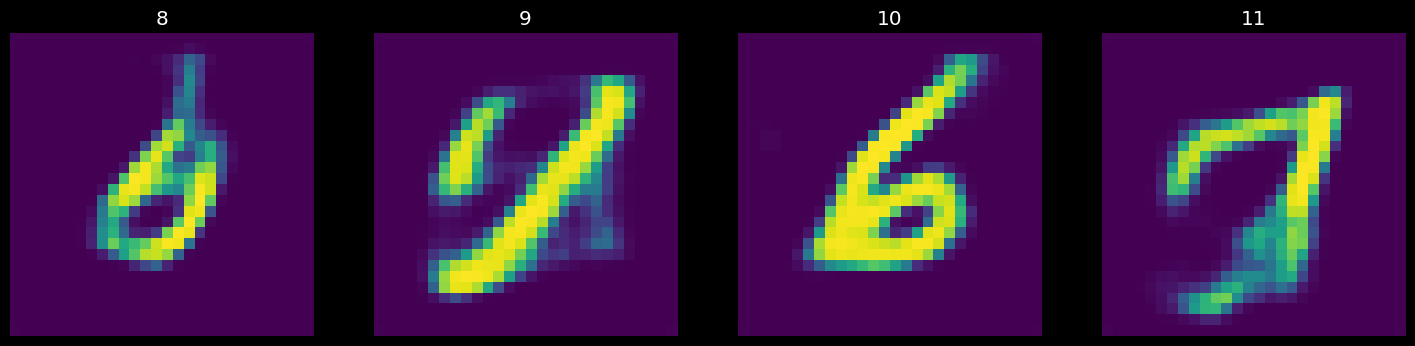

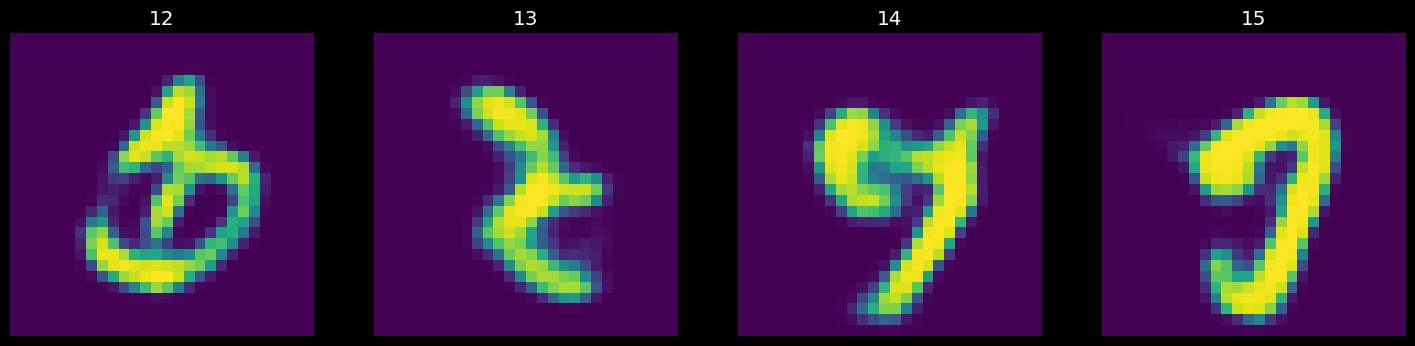

In [48]:
# Display last test batch

display_images(None, x, 4, count=True)

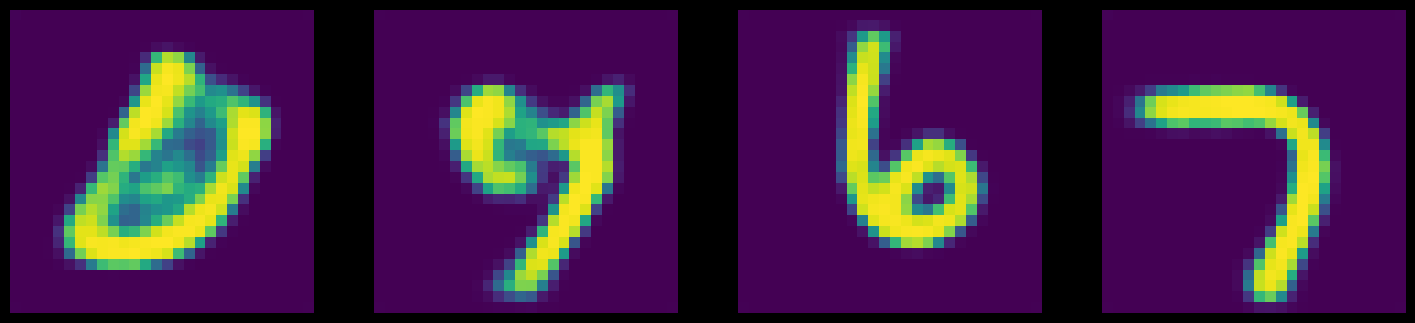

In [56]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decode(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0].view(-1),
    sample.data[1].view(-1)
)), 0))

In [59]:
mu[A].shape

torch.Size([20])

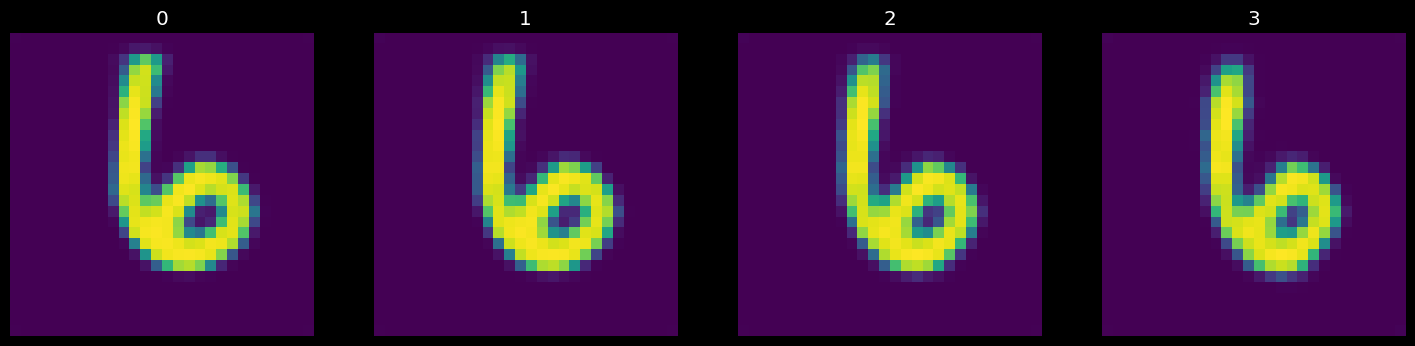

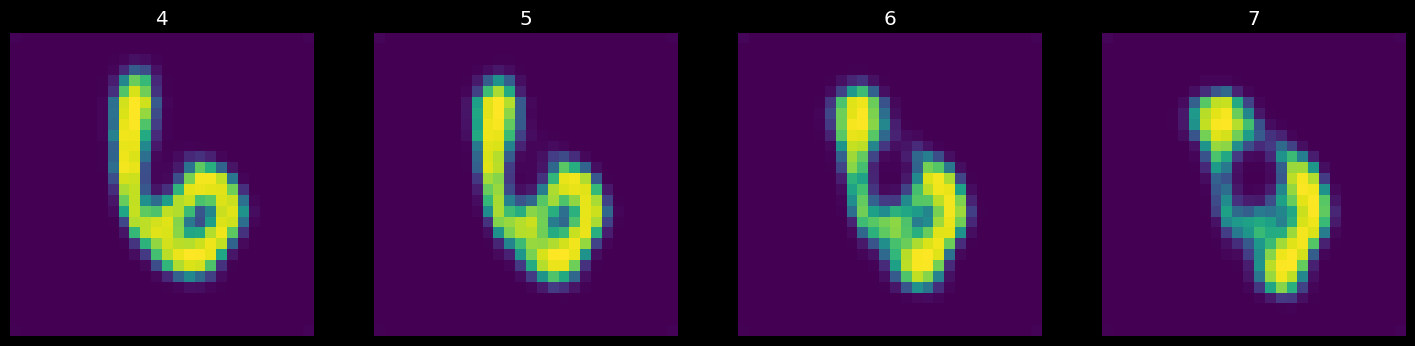

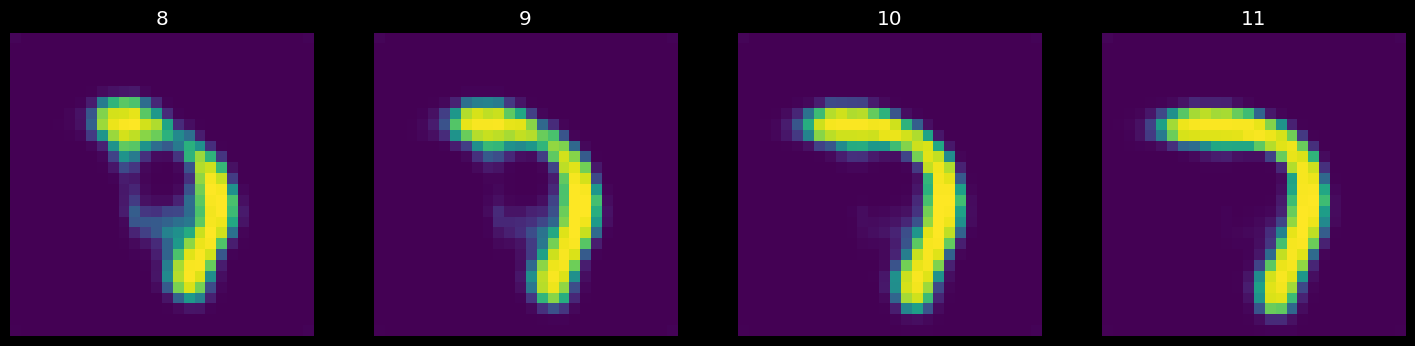

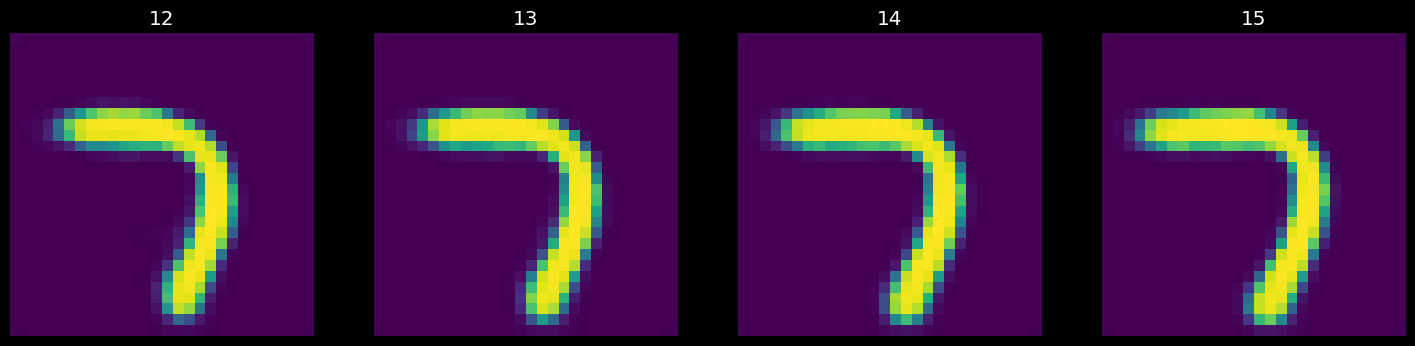

In [57]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decode(code).view(-1, 784)
display_images(None, sample, N // 4, count=True)

In [60]:
import numpy as np
from sklearn.manifold import TSNE
from res.plot_lib import set_default

In [61]:
set_default(figsize=(15, 4))

In [62]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].cpu()))
    Y.append(codes['y'][epoch][:N])

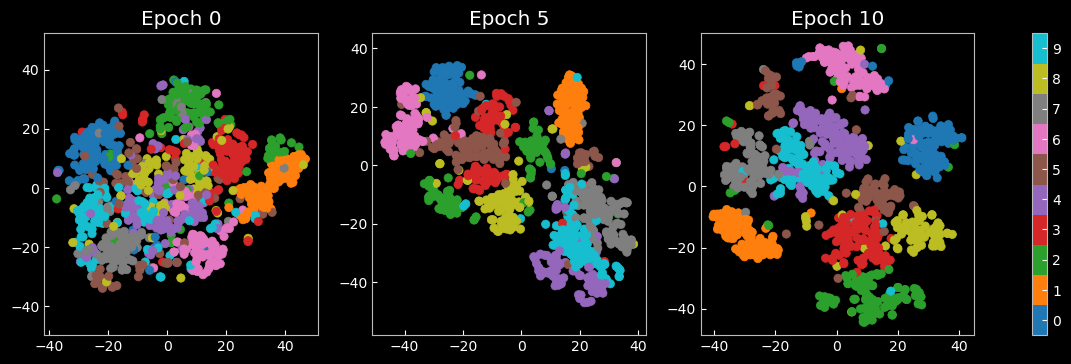

In [63]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)